# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.  

## Описание данных

* `airports_nearest` — расстояние до ближайшего аэропорта в метрах (м)
* `balcony` — число балконов
* `ceiling_height` — высота потолков (м)
* `cityCenters_nearest` — расстояние до центра города (м)
* `days_exposition` — сколько дней было размещено объявление (от публикации до снятия)
* `first_day_exposition` — дата публикации
* `floor` — этаж
* `floors_total` — всего этажей в доме
* `is_apartment` — апартаменты (булев тип)
* `kitchen_area` — площадь кухни в квадратных метрах (м²)
* `last_price` — цена на момент снятия с публикации
* `living_area` — жилая площадь в квадратных метрах(м²)
* `locality_name` — название населённого пункта
* `open_plan` — свободная планировка (булев тип)
* `parks_around3000` — число парков в радиусе 3 км
* `parks_nearest` — расстояние до ближайшего парка (м)
* `ponds_around3000` — число водоёмов в радиусе 3 км
* `ponds_nearest` — расстояние до ближайшего водоёма (м)
* `rooms` — число комнат
* `studio` — квартира-студия (булев тип)
* `total_area` — площадь квартиры в квадратных метрах (м²)
* `total_images` — число фотографий квартиры в объявлении

## План
1. **Ознакомление с данными**  
    1.1. изменение типов данных  
    1.2. общая оценка данных  
2. **Предобработка данных**  
    2.1. работа с пропущенными данными  
        2.1.1. LOCALITY_NAME  
        2.1.2. IS_APARTMENT  
        2.1.3. PONDS and PARKS  
        2.1.4. BALCONY  
        2.1.5. LIVING_AREA  
        2.1.6. KITCHEN_AREA  
        2.1.7. Остальные показатели  
    2.2. Работа с дубликатами
3. **Вспомогательные данные**  
    3.1. SQ_METER_PRICE  
    3.2. WEEKDAY, MONTH, YEAR  
    3.3. FLOOR_TYPE  
    3.4. CITY_CENTER_KM  
4. **Исследовательский анализ данных**  
    4.1 Работа с выбросами  
        4.1.1. TOTAL_AREA    
        4.1.2. LIVING_AREA  
        4.1.3. KITCHEN_AREA  
        4.1.4. LAST_PRICE  
        4.1.5. ROOMS  
        4.1.6. СEILING_HEIGHT  
        4.1.7. FLOORS_TOTAL  
        4.1.8. FLOOR_TYPE  
        4.1.9. CITY_CENTERS_NEAREST  
        4.1.10. PARKS_NEAREST  
    4.2 Скорость продажи квартиры  
    4.3 Факторы, влияющие на стоимость объекта  
    4.4 Расчёт средней стоимости квадратного метра  
    4.5 Стоимость квартиры и удалённость от центра  
5. **Общие выводы**  

****

## 1. Ознакомление с данными

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

try:
    data = pd.read_csv('D:\docs\DS\real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')
    

data.head(15)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,...,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,...,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,...,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,...,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,...,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,...,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,...,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


все столбцы проименованы в дином стиле, кроме `cityCenters_nearest`, приведём названия к единообразию стиля:

In [2]:
data.rename(columns={'cityCenters_nearest' : 'city_centers_nearest'}, inplace = True)

### 1.1 изменение типов данных
с первого взгляда в отображаемой части датасета можно отметить многочисленные пропуски, а также некорректное отображение даты. посмотрим на общую информацию по датасету:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

действительно, дата записана в формате object, а некоторым категориальным данным присвоен тип int64, который для ускорения работы можно заменить на category. к такиим данным относятся: `parks_around3000`, `ponds_around3000`. при этом оставим без изменений тип данных для столбцов `total_images`, `rooms` `floors_total`, `floor`, `balcony` &mdash; в дальнейшем это пригодится нам для формирования срезов и построения графиков.

в столбце `is_apartment` очевидно должны содержаться булевы данные, но ему присвоен тип object &mdash; из-за пропусков. пока оставим этот столец без изменений.

In [4]:
# напишем цикл, который задаст новый тип данных для нужных столбцов:
for column in ['parks_around3000', 'ponds_around3000']:
    data[column] = data[column].astype('category')
    
# также изменим тип данных first_day_exposition:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'])

# ещё раз посмотрим на параметры нашего датасета:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          2775 non-null   object        
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

### 1.2 общая оценка данных

в датасет содержит 23699 наблюдений, столбцы названы корректно, без кириллицы и пробелов, типы данных обозначены верно, однако бросается в глаза наличие пробелов в данных. чтобы предварительно оценить масштабы бедствия, для каждого столбца посчитаем количество пропусков, а также их долю от общего числа наблюдений:

In [5]:
missing_data_start = data.isna().sum().to_frame().rename(columns = {0: 'missing_values_start'})

missing_data_start['total_values_start'] = data.shape[0]
missing_data_start['% of total_start'] = (missing_data_start['missing_values_start'] / data.shape[0] * 100).round(2)

missing_data_start.sort_values('missing_values_start', ascending = False)

,missing_values_start,total_values_start,% of total_start
is_apartment,20924,23699,88.29
parks_nearest,15620,23699,65.91
ponds_nearest,14589,23699,61.56
balcony,11519,23699,48.61
ceiling_height,9195,23699,38.80
airports_nearest,5542,23699,23.38
city_centers_nearest,5519,23699,23.29
ponds_around3000,5518,23699,23.28
parks_around3000,5518,23699,23.28
days_exposition,3181,23699,13.42


в некоторых столбцах наблюдается значительное количество пропусков, от 20% и выше &mdash; мы учтём это далее в исследовании.  
для первичного ознакомления с данными построим гистограмму каждого числового столбца датасета:

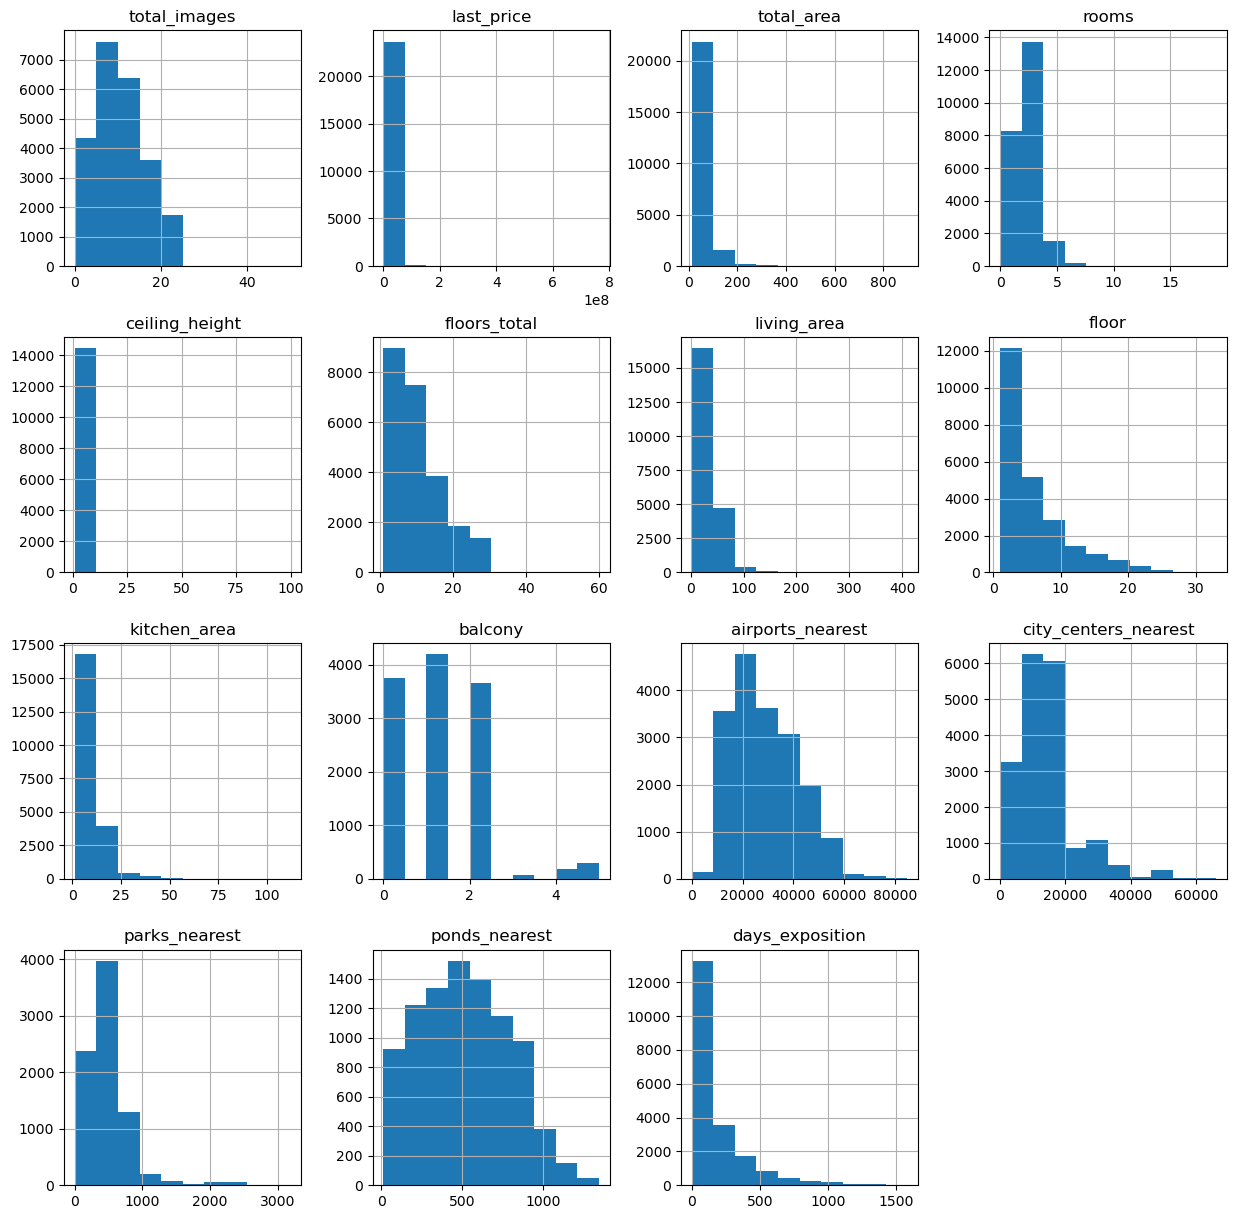

In [6]:
data.select_dtypes(include=['int64', 'float64']).hist(figsize=(15, 15))
plt.show()

в результате предварительного знакомства с данными мы облегчили датасет, заменив некоторые численные значения на категориальные, оценили количество пропусков и зафиксировали их в переменной `missing_data_start`. позже мы к ней вернёмся, чтобы оценить изменения в датасете, которые повлечёт предобработка данных.  
ознакомительные гистограммы позводяют предположить выбросы: например, дома выше 30 этажей или более 4 балконов в квартире. скорее всего, ошибки заполнения данных об объекте &mdash; рассмотрим подробнее проблемные объекты, когда будем работать с выбросами.

## 2. Предобработка данных
### 2.1. работа с пропущенными данными
#### 2.1.1 LOCALITY_NAME

начнём работу с пропусками в наиболее важном для исследования столбце: название населённого пункта (`locality_name`). напомню, что в данном столбце у нас 49 наблюдений, у которых этот параметр не указан. посмотрим на такие объекты:

In [7]:
data[data['locality_name'].isna()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1097,3,8600000.0,81.70,2016-04-15,3,3.55,5.0,50.80,2,NaN,...,8.80,0.0,NaN,23478.0,4258.0,0.0,NaN,0.0,NaN,147.0
2033,6,5398000.0,80.00,2017-05-30,3,NaN,4.0,42.60,2,NaN,...,18.60,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.0
2603,20,3351765.0,42.70,2015-09-20,1,NaN,24.0,15.60,3,NaN,...,10.70,0.0,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,276.0
2632,2,5130593.0,62.40,2015-10-11,2,NaN,24.0,33.10,21,NaN,...,8.20,0.0,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,256.0
3574,10,4200000.0,46.50,2016-05-28,2,NaN,5.0,30.80,5,NaN,...,6.50,0.0,NaN,27419.0,8127.0,0.0,NaN,1.0,603.0,45.0
4151,17,17600000.0,89.50,2014-12-09,2,3.00,8.0,39.62,7,NaN,...,13.38,0.0,NaN,25054.0,3902.0,1.0,485.0,3.0,722.0,869.0
4189,7,9200000.0,80.00,2015-12-10,3,4.00,4.0,52.30,3,False,...,10.40,0.0,NaN,21774.0,3039.0,1.0,690.0,1.0,953.0,223.0
4670,1,5500000.0,83.00,2015-08-14,3,NaN,7.0,NaN,6,NaN,...,NaN,0.0,NaN,26534.0,5382.0,1.0,446.0,1.0,376.0,350.0
5343,19,13540000.0,85.50,2016-01-20,3,NaN,7.0,59.10,5,False,...,8.30,4.0,NaN,10556.0,9538.0,1.0,67.0,0.0,NaN,303.0
5707,7,3700000.0,30.00,2016-04-29,1,NaN,24.0,20.00,23,NaN,...,NaN,0.0,NaN,21460.0,16788.0,0.0,NaN,1.0,170.0,49.0


объекты весьма разношёрстные: разнятся и по метражу, и по стоимости, и по этажности домов &mdash; предположить или угадать город, в котором они могут находиться, не представляется возможным. так как количество таких наблюдений составняет всего **0.21%** от выборки, их можно удалить без ущерба для общей картины.

In [8]:
data.dropna(subset=['locality_name'], inplace=True) # удалим строки, содержашие пропуски в столбце locality_name
data[data['locality_name'].isna()]['locality_name'] # проверим, результат

Series([], Name: locality_name, dtype: object)

#### 2.1.2 IS_APARTMENT
теперь изучим чемпиона по пропускам. посмотрим, как пользователи заполняли это поле:

In [9]:
data[data['is_apartment'].notna()]['is_apartment'].value_counts()

is_apartment
False    2710
True       50
Name: count, dtype: int64

In [10]:
data.query('is_apartment.notna()')['locality_name'].value_counts()

locality_name
Санкт-Петербург                        1833
посёлок Шушары                           58
посёлок Мурино                           54
деревня Кудрово                          48
Пушкин                                   48
                                       ... 
поселок городского типа Кондратьево       1
коттеджный поселок Счастье                1
поселок Суходолье                         1
поселок городского типа Лебяжье           1
посёлок Понтонный                         1
Name: count, Length: 140, dtype: int64

всего 2760 пользователей определили этот параметр и большинство из них указало, что объект не является апартаментами. так как апартаменты юридически не являются жилой недвижимостью, цена на них обычно ниже, чем на квартиры. в Петербурге 1833 объекта с заполненным атрубутом `is_apartments`: этого должно хватить, для того чтобы сравнить цены на апартаменты и квартиры.

In [11]:
aparts= (data.query('is_apartment.notna()') # формируем срез: берём только те строки, где нет пропуска
.pivot_table(index='locality_name', columns='is_apartment', 
             values=['last_price', 'total_area'], aggfunc='median') # формируем сводную таблицу
        )

aparts.columns= ['not_apartment_price', 'is_apartment_price', 'not_apartment_area', 'apartment_area'] # задаём понятные названия для колонок      
(aparts.dropna() # отсеем строки с пропусками
.reset_index() # сбросим индекс,
.query('locality_name == "Санкт-Петербург"') # чтобы сделать срез по городу
)


,locality_name,not_apartment_price,is_apartment_price,not_apartment_area,apartment_area
7,Санкт-Петербург,5500000.0,6900000.0,56.0,58.0


в получившихся данных в большинстве случаев наблюдается обратная ситуация: медианная цена апартаментов выше, чем цена квартир, притом что медианная площадь таких объектов примерно одинаковая. из чего можно сделать вывод, что пользователи, заполнявшие поле `is_apartment`, не всегда делали это корректно, что можно объяснить тем, что данный тип недвижимости появился сравнительно недавно. однако, напомним, что в датасете более **88%** наблюдений, у которых это поле оставлено пустым. в данном случае заполнять пропуски или удалять строки, которые их содержат, нецелесообразно. будет лучше не учитывать данную характеристику в нашем исследовании.

#### 2.1.3 PONDS and PARKS

далее по списку пропусков:  
`parks_nearest	            15620      65.91%`  
`ponds_nearest	            14589      61.56%`  
`ponds_around3000           5518       23.30%`    
`parks_around3000           5518       23.30%`  

количество пропусков слишком велико, оставим данные без изменений. в данном исследовании не будем опираться на эти характеристики

#### 2.1.4 BALCONY
в исходном датасете у этого поля довольно много пропусков:  
`balcony                        11519       48.61`  
почти у половины объектов датасета данное поле не заполнено. посмотрим, в каких городах и как часто пользователи забывали вносить информацию о количестве балконов:

In [12]:
data.query('balcony.isna()')['locality_name'].value_counts()

locality_name
Санкт-Петербург                     7712
посёлок Мурино                       242
Всеволожск                           188
посёлок Шушары                       181
Пушкин                               170
                                    ... 
садовое товарищество Новая Ропша       1
село Паша                              1
поселок Серебрянский                   1
посёлок Алексеевка                     1
село Рождествено                       1
Name: count, Length: 288, dtype: int64

подавляющее количество объектов находится в Петербурге, что естественно. также значительное количество есть в Мурине, Всеволожске и Шушарах. давайте проверим, на каких этажах находятся квартиры, у которых не отметили наличие балкона:

In [13]:
data.query("balcony.isna() and locality_name.isin(['Санкт-Петербург', 'посёлок Мурино', 'Всеволожск', 'посёлок Шушары'])").pivot_table(index=['floor'], columns='locality_name', values='total_area', aggfunc='count')

locality_name,Всеволожск,Санкт-Петербург,посёлок Мурино,посёлок Шушары
floor,,,,
1,40.0,1085.0,11.0,27.0
2,43.0,1135.0,9.0,22.0
3,31.0,1021.0,18.0,29.0
4,16.0,931.0,12.0,14.0
5,15.0,796.0,11.0,17.0
6,11.0,450.0,10.0,12.0
7,5.0,393.0,15.0,7.0
8,6.0,359.0,12.0,5.0
9,8.0,310.0,14.0,6.0


как и предполагалось, большая часть этих объектов находится на первом этаже. в Петербурге также много таких квартир на 2-5 этажах, что легко объясняется наличием домов прошого века, в которых либо изначально не было балкона, либо он был демонтирован. что касается балконов на высоких этажах (не будем брать в расчёт очевидные выбросы), можно предположить, что это квартиры в новостройках, зачастую, студии либо небольшие по метражу квартиры, которые часто не имеют балкона.   
в данном случае пропуски можно смело заменять нулями:

In [14]:
data['balcony'] = data['balcony'].fillna(0)
print(f"Объекты, у которых не указано количество балконов: {len(data.query('balcony.isna()'))}")

Объекты, у которых не указано количество балконов: 0


#### 2.1.5 LIVING_AREA
количество пропусков в данном столбце сравнительно небольшое:  
`living_area                     1903        8.03%`  

данный показатель является важным для определения стоимости квартиры. для начала посмотрим, в квартирах какого типа не указана жилая площадь.

In [15]:
(data.query('living_area.isna()')[['total_area','rooms','open_plan', 'studio']] 
 .sort_values(['rooms', 'total_area'], ascending=False)
)


,total_area,rooms,open_plan,studio
8860,235.0,9,False,False
3117,631.0,7,False,False
5873,400.0,7,False,False
581,365.0,7,False,False
10684,364.7,7,False,False
...,...,...,...,...
608,25.0,0,False,True
5749,25.0,0,True,False
4901,24.0,0,False,True
3874,21.4,0,False,True


жилая площадь не указана и в многокомнатных квартирах, и в студиях: всего вышло **1898** объектов. заменим отсутствующие значения на медианный для квартир с соответствующим количеством комнат. но для начала посмотрим, каковы минимальные показатели для квартир в зависимости от количества комнат:

In [16]:
rooms_pivot_data = (data.pivot_table(index='rooms', 
                                            values=['total_area', 'living_area', 'kitchen_area'], 
                                            aggfunc='median')
                   )

rooms_pivot_data

,kitchen_area,living_area,total_area
rooms,,,
0,NaN,18.000,26.05
1,9.01,17.600,36.53
2,8.80,30.500,53.00
3,9.50,45.000,72.90
4,11.05,63.800,99.50
5,15.10,91.785,146.45
6,19.50,123.900,184.30
7,20.00,145.000,214.00
8,25.00,161.000,235.70


напишем функцию, которая подставит вместо отсутствующих значений жилой площади минимальное значение с учётом количества комнат:

In [17]:
def set_living_area(row):
    
    living_area = row['living_area']
    rooms = row['rooms']

    if pd.isna(row.living_area):
        return rooms_pivot_data.iloc[rooms, 1]

    return living_area

применим данную функцию к столбцу `living_area` и проверим результат:

In [18]:
data['living_area'] = data.apply(set_living_area, axis = 1)

print(f"Количество пропусков в living_area: {data.query('living_area.isna()')['living_area'].count()}")

Количество пропусков в living_area: 0


теперь проверим, сколько в столбце `living_area` значений меньше  9 м<sup>2</sup> - это минимальная площадь жилого пространства в квартире.

In [19]:
data.query('living_area < 9')[['living_area', 'kitchen_area', 'total_area', 'rooms']]

,living_area,kitchen_area,total_area,rooms
114,8.3,6.3,21.4,1
2309,8.4,41.0,62.4,2
3242,3.0,11.0,41.0,1
13915,2.0,9.0,52.0,2
16431,6.0,17.0,31.0,1
17248,8.9,16.1,33.0,1
17582,5.0,NaN,22.0,0
19251,6.5,18.0,33.0,1
20994,8.0,31.0,50.6,2
21505,8.5,16.1,35.3,1


таких значений немного, однако у всех квартир из этого списка показатель общей площади адекватный. оставим эти данные для анализа других характеристик. для исследования корреляции между ценой и жилой площадью возьмём срез `living_area >= 9`

#### 2.1.6 KITCHEN_AREA

количество пропусков в данном столбце незначительно превышает количество пропусков в жилой площади:  
`kitchen_area                    2278        9.61%`  

заполним эти пропуски по тому же принципу, который использовали для устранения пропусков в `living_area`. посчитаем медианные значения площади кухни, построив сводную таблицу по заданному срезу: площадь кухни 5 и более квадратных метров (существующие нормы минимальной площади кухни-ниши).

важно помнить: в старом фонде Петербурга и пригородов могут встречаться нестандартные крошечные кухни менее 5 м<sup>2</sup>, однако, доля таких квартир сравнительно невелика.

In [20]:
kitchen_pivot_data = (data.query('kitchen_area >= 5')
                      .pivot_table(index='rooms', 
                                   values=['total_area', 'living_area', 'kitchen_area'], 
                                   aggfunc='median')
                     )
kitchen_pivot_data

,kitchen_area,living_area,total_area
rooms,,,
1,9.10,17.60,36.9
2,8.80,30.50,53.0
3,9.50,45.00,73.0
4,11.10,63.80,99.5
5,15.10,91.80,146.9
6,19.50,123.90,183.7
7,20.00,145.00,212.0
8,25.00,160.00,235.0
9,14.30,179.20,309.7


In [21]:
def set_kitchen_area(row):
    
    kitchen_area = row['kitchen_area']
    rooms = row['rooms']

    if pd.isna(row.kitchen_area):
        return kitchen_pivot_data.iloc[rooms, 0]

    return kitchen_area

# применим функцию подстановки площади и вывдем результат:
data['kitchen_area'] = data.apply(set_kitchen_area, axis = 1)

print(f"Количество пропусков в kitchen_area: {data.query('kitchen_area.isna()')['kitchen_area'].count()}")

Количество пропусков в kitchen_area: 0


#### 2.1.7 Остальные показатели

рассмотрим оставшиеся столбцы с пропусками:
1. `ceiling_height                  9195       38.80%`
2. `airports_nearest                5542       23.38%`
3. `cityCenters_nearest             5519       23.29%`
4. `days_exposition                 3181       13.42%`
5. `floors_total                      86        0.36%`  

позиции 2-4 &mdash; данные, собранные автоматически. ни один из этих показателей не представляется возможным заполнить средними или медианными значениями. так как у нас нет возможности запросить корректировку датасета у коллег, будем работать с тем, что есть.

`floors_total` &mdash; процент пропусков мал и не окажет существенного влияния на датасет. чтобы не терять данные по прочим показателям, оставим эти наблюдения. в дальнейшем анализе будем пользоваться срезом данных.

`ceiling_height`. почти десять тысяч человек не указали высоту потолков у продаваемых квартир. в старых домах Петербурга и исторических пригородов высота потолков может удивлять, поэтому заполнять пропуски усреднённым или медианным значением не стоит. так же, как и в случае с пропусками автоматических данных, нам придётся работать с тем, что есть.  далее в исследовании мы вернёмся к этому столбцу и проверим данные на адекватность, а также поработаем с выбросами.

#### Промежуточный итог
- удалены строки, в которых отсутствуют ключевые показатели (название города)
- столбцы с большим количеством пропусков, паттерн возникновения которых не прослеживается, оставили без изменений 
- в картогафических данных о парках и озёрах заполнили нули, руководствуясь логикой: если расстояние до объекта не задано, значит, объект не найден. при этом в датасете не было обнаружено строк, для которых указано расстояние до парка / озера, но не указано количество озёр.
- для living_area и kitchen_area заменили пропуски на минимальное значение площади в квартирах с соответствующим количеством комнат.

### 2.2 Работа с дубликатами
для начала проверим, нет ли в датасете явных дубликатов:

In [22]:
data.duplicated().sum()

0

полных дубликатов в датасете не обнаружено, давайте поработаем с неявными дубликатами, которые могут содержаться в столбце `locality_name`: унифицировав варианты написания городов, мы можем получить дублирующиеся строки. посмотрим на уникальные значения в этом столбце:

In [23]:
print(f"Количество уникальных названий: {len(data['locality_name'].unique())} \n \n"
      f"Список уникальных названий: \n {data['locality_name'].unique()}"
     )

Количество уникальных названий: 364 
 
Список уникальных названий: 
 ['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссе

первое, что бросается в глаза, это посёлок и поселок. унифицируем написание, чтобы устранить неявные дубликаты:

In [24]:
data['locality_name'] = data['locality_name'].replace(r"\поселок", "посёлок", regex=True)

print(f"Количество уникальных названий: {len(data['locality_name'].unique())} \n \n"
      f"Список уникальных названий: \n {data['locality_name'].unique()}"
     )

Количество уникальных названий: 330 
 
Список уникальных названий: 
 ['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'посёлок городского типа Красный Бор' 'Гатчина' 'деревня Фёдоровское'
 'Выборг' 'Кронштадт' 'Кировск' 'деревня Новое Девяткино'
 'посёлок Металлострой' 'посёлок городского типа Лебяжье'
 'посёлок городского типа Сиверский' 'посёлок Молодцово'
 'посёлок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'посёлок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'посёлок Торковичи'
 'посёлок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольск

на первом шаге нам удалось устранить 34 дубля.  
с помощью лемматизации определим, какие элементы названий повторяются более одного раза (не будем принимать во внимание повторяющиеся типы поселений вроде "деревня", "село", "станция" и т.д.)

In [25]:
# !pip install pymystem3

In [26]:
from pymystem3 import Mystem
m = Mystem()
from collections import Counter

names = data['locality_name'].unique()
text = ''

for i in names:
    text += str(i) + ' '

lemmas = m.lemmatize(text)
print(Counter(lemmas))

Counter({' ': 753, 'поселок': 167, 'деревня': 106, 'городской': 43, 'тип': 30, '-': 10, 'село': 10, 'станция': 8, 'большой': 7, 'бор': 6, 'старый': 6, 'новый': 5, 'товарищество': 5, 'красный': 4, 'садовый': 4, 'малый': 4, 'павлово': 3, 'ижора': 3, 'лесной': 3, 'коттеджный': 3, 'муриный': 2, 'кудрово': 2, 'коммунар': 2, 'федоровский': 2, 'ропша': 2, 'никольское': 2, 'сосновый': 2, 'романовка': 2, 'рощино': 2, 'луг': 2, 'советский': 2, 'лесогорский': 2, 'рахья': 2, 'колпана': 2, 'ладога': 2, 'зимитиц': 2, 'имя': 2, 'рябово': 2, 'бегуница': 2, 'поляна': 2, 'мга': 2, 'вещево': 2, 'приладожский': 2, 'щегловый': 2, 'рабитиц': 2, 'назия': 2, 'саперный': 2, 'гарболовый': 2, 'приветнинский': 2, 'усть': 2, 'любань': 2, 'горка': 2, 'при': 2, 'железнодорожный': 2, 'громовый': 2, 'тесовый': 2, 'нижний': 2, 'санкт-петербург': 1, 'шушар': 1, 'янино': 1, '1': 1, 'парголовый': 1, 'ломоносов': 1, 'сертолово': 1, 'петергоф': 1, 'пушкин': 1, 'колпино': 1, 'гатчина': 1, 'выборг': 1, 'кронштадт': 1, 'кировс

выведем полное название населённых пунктов, элементы которых дублируются в списке:

In [27]:
data.query('locality_name.str.contains("Мурино") or \
            locality_name.str.contains("Кудрово") or \
            locality_name.str.contains("Фёдоровское") or \
            locality_name.str.contains("Рощино") or \
            locality_name.str.contains("Павлово") or \
            locality_name.str.contains("Ижора") or \
            locality_name.str.contains("Коммунар") or \
            locality_name.str.contains("Ропша") or \
            locality_name.str.contains("Никольское") or \
            locality_name.str.contains("Романовка") or \
            locality_name.str.contains("Луг") or \
            locality_name.str.contains("Рахья") or \
            locality_name.str.contains("Ладога") or \
            locality_name.str.contains("Рябово") or \
            locality_name.str.contains("Мга") or \
            locality_name.str.contains("Вещево") or \
            locality_name.str.contains("Усть") or \
            locality_name.str.contains("Любань") or \
            locality_name.str.contains("Бегуниц") or \
            locality_name.str.contains("Бор")')['locality_name'].value_counts()

locality_name
посёлок Мурино                                556
деревня Кудрово                               299
Кудрово                                       173
Никольское                                     93
Коммунар                                       89
Сосновый Бор                                   87
Луга                                           56
посёлок Романовка                              36
Мурино                                         34
посёлок городского типа Рощино                 34
городской посёлок Мга                          27
деревня Бегуницы                               17
городской посёлок Большая Ижора                16
посёлок городского типа Рахья                  15
Новая Ладога                                   14
городской посёлок Павлово                       9
деревня Фёдоровское                             8
посёлок городского типа Красный Бор             8
Любань                                          8
городской посёлок Фёдоровское       

проверив с помощью Яедкс.карт, действительно ли населённые пункты со схожими названиями являются разными, напишем функцию, которая возвращает общее для дублей корректное название:

In [28]:
def set_correct_names(name):
    if "посёлок городского типа Павлово" in name:
        return "городской посёлок Павлово"
    if "Мурино" in name:
        return "Мурино"
    if "Кудрово" in name:
        return "Кудрово"
    if "Фёдоровское" in name:
        return "городской посёлок Фёдоровское"
    if "Рощино" in name: 
        return "городской посёлок Рощино"
    if "Мга" in name:
        return "городской посёлок Мга"
    if "Ижора" in name:
        return "городской посёлок Ижора"
    return name

на первом шаге мы срезали 34 дубля, и в датасете осталось 330 уникальных названий населённых пунктов, пропустим этот список через нашу функцию, занесём данные в отдельный столбец:

In [29]:
data['correct_names'] = data['locality_name'].apply(set_correct_names)

print(f"Количество уникальных названий: {len(data['correct_names'].unique())} \n \n"
      f"Список уникальных названий: \n {data['correct_names'].unique()}"
     )

Количество уникальных названий: 322 
 
Список уникальных названий: 
 ['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'Мурино' 'Ломоносов' 'Сертолово' 'Петергоф' 'Пушкин'
 'Кудрово' 'Коммунар' 'Колпино' 'посёлок городского типа Красный Бор'
 'Гатчина' 'городской посёлок Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'посёлок Молодцово' 'посёлок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'посёлок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'посёлок Торковичи'
 'посёлок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Шлиссельбург' 'Никольское' 'Зеленогорск

мы избавились ещё от 8 неявных дубликатов, проверим, повлияло ли это на наличие явных зубликатов в датасете:

In [30]:
data.duplicated().sum()

0

явных дубликатов в данных нет. перед тем как подводить промежуточные итоги, оценим финальное количество пропусков:

In [31]:
missing_data = data.isna().sum().to_frame().rename(columns = {0: 'missing_values'})

missing_data['% of total'] = (missing_data['missing_values'] / data.shape[0] * 100).round(2)
missing_data.sort_values('missing_values', ascending = False)

,missing_values,% of total
is_apartment,20890,88.33
parks_nearest,15586,65.90
ponds_nearest,14565,61.59
ceiling_height,9160,38.73
airports_nearest,5534,23.40
city_centers_nearest,5511,23.30
ponds_around3000,5510,23.30
parks_around3000,5510,23.30
days_exposition,3180,13.45
floors_total,85,0.36


### Промежуточные итоги
поиск дубликатов не выявил повторяющихся строк, однако нам удалось унифицировать 42 названия населённых пунктов. в дальнейшем это поможет нам собирать более точные подсчёты, связанные с этой характеристикой.

в датасете довольно много пропусков, часть из них следствие человеческого фактора (не указана этажность домов или количество балконов), некоторые пропуски очевидно результат технической ошибки переноса или сбора данных. эти данные мы оставили без изменений и не будем опираться на них в рамках данного исследования.

всего на шаге предобработки данных было удалено 49 строк датасета, в которых отсутствовала ключевая характеристика объекта. датасет готов к добавлению вспомогательных данных и исследовательскому анализу.

## 3. Вспомогательные данные

добавим в датасет новые столбцы, которые пригодятся нам в анализе данных: 
- `sq_meter_price` &mdash; цена квадратного метра
- `weekday` &mdash; день недели, в который было опубликовано объявление
- `month` &mdash; месяц публикации объявления
- `year` &mdash; год публикации объявления
- `floor_type` &mdash; тип этажа: первый, последний и другой
- `city_center_km` &mdash; расстояние от центра города в километрах  
### 3.1. SQ_METER_PRICE
посчитаем стоимость квадратного метра для каждого объекта датасета, результат запишем в новом столбце `sq_meter_price`.
округлим результаты и преобразуем тип данных в `int`.  
т.к. речь идёт о недвижимости, погрешностью округления в 1 рубль в данной операции можно пренебречь.

In [32]:
data['sq_meter_price'] = (data['last_price'] / data['total_area']).astype('int')
data.head(15)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,correct_names,sq_meter_price
0,20,13000000.0,108.00,2019-03-07,3,2.70,16.0,51.00,8,NaN,...,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,Санкт-Петербург,120370
1,7,3350000.0,40.40,2018-12-04,1,NaN,11.0,18.60,1,NaN,...,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,посёлок Шушары,82920
2,10,5196000.0,56.00,2015-08-20,2,NaN,5.0,34.30,4,NaN,...,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,Санкт-Петербург,92785
3,0,64900000.0,159.00,2015-07-24,3,NaN,14.0,45.00,9,NaN,...,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,Санкт-Петербург,408176
4,2,10000000.0,100.00,2018-06-19,2,3.03,14.0,32.00,13,NaN,...,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,Санкт-Петербург,100000
5,10,2890000.0,30.40,2018-09-10,1,NaN,12.0,14.40,5,NaN,...,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,городской посёлок Янино-1,95065
6,6,3700000.0,37.30,2017-11-02,1,NaN,26.0,10.60,6,NaN,...,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0,посёлок Парголово,99195
7,5,7915000.0,71.60,2019-04-18,2,NaN,24.0,30.50,22,NaN,...,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN,Санкт-Петербург,110544
8,20,2900000.0,33.16,2018-05-23,1,NaN,27.0,15.43,26,NaN,...,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0,Мурино,87454
9,18,5400000.0,61.00,2017-02-26,3,2.50,9.0,43.60,7,NaN,...,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0,Санкт-Петербург,88524


### 3.2. WEEKDAY, MONTH, YEAR
преобразуем данные о дате публикации объявления: добавим столбцы с информацией о дне недели, месяце и годе публикации. результат преобразования отобразим в виде цифр, так как дальнейшие операции потребуют от нас численный, а не строковый тип данных

In [33]:
data['weekday'] = data['first_day_exposition'].dt.weekday 
data['month'] = data['first_day_exposition'].dt.month 
data['year'] = data['first_day_exposition'].dt.year
data.head(15)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,correct_names,sq_meter_price,weekday,month,year
0,20,13000000.0,108.00,2019-03-07,3,2.70,16.0,51.00,8,NaN,...,1.0,482.0,2.0,755.0,NaN,Санкт-Петербург,120370,3,3,2019
1,7,3350000.0,40.40,2018-12-04,1,NaN,11.0,18.60,1,NaN,...,0.0,NaN,0.0,NaN,81.0,посёлок Шушары,82920,1,12,2018
2,10,5196000.0,56.00,2015-08-20,2,NaN,5.0,34.30,4,NaN,...,1.0,90.0,2.0,574.0,558.0,Санкт-Петербург,92785,3,8,2015
3,0,64900000.0,159.00,2015-07-24,3,NaN,14.0,45.00,9,NaN,...,2.0,84.0,3.0,234.0,424.0,Санкт-Петербург,408176,4,7,2015
4,2,10000000.0,100.00,2018-06-19,2,3.03,14.0,32.00,13,NaN,...,2.0,112.0,1.0,48.0,121.0,Санкт-Петербург,100000,1,6,2018
5,10,2890000.0,30.40,2018-09-10,1,NaN,12.0,14.40,5,NaN,...,NaN,NaN,NaN,NaN,55.0,городской посёлок Янино-1,95065,0,9,2018
6,6,3700000.0,37.30,2017-11-02,1,NaN,26.0,10.60,6,NaN,...,0.0,NaN,0.0,NaN,155.0,посёлок Парголово,99195,3,11,2017
7,5,7915000.0,71.60,2019-04-18,2,NaN,24.0,30.50,22,NaN,...,0.0,NaN,0.0,NaN,NaN,Санкт-Петербург,110544,3,4,2019
8,20,2900000.0,33.16,2018-05-23,1,NaN,27.0,15.43,26,NaN,...,NaN,NaN,NaN,NaN,189.0,Мурино,87454,2,5,2018
9,18,5400000.0,61.00,2017-02-26,3,2.50,9.0,43.60,7,NaN,...,0.0,NaN,0.0,NaN,289.0,Санкт-Петербург,88524,6,2,2017


### 3.3 FLOOR_TYPE
определим тип этажа для каждой из квартир в датасете. для этого напишем функцию, которая распределит объекты по типу этажа: первый, последний или другой. не у всех квартир в датасете есть информация об этажности дома:

`floors_total                      85        0.36%`

однако таких объектов не очень много, всего 0.36%, для них определим тип этажа "другой", как и для квартир, которые находятся не на первом и не на последнем этаже.

In [34]:
def set_floor_type(row):
    
    floor = row['floor']
    floors_total = row['floors_total']
    
    if pd.isna(row.floors_total):
        return 'другой'
    
    if floor == 1:
        return 'первый'
    
    if floor == floors_total:
        return 'последний'
    
    return 'другой'

data['floor_type'] = data.apply(set_floor_type, axis=1)
print(f"Проверим результат: \n {data[['floor', 'floors_total', 'floor_type']].head(5)} \n \n"
      f"Проверим тип этажа у обектов с неуказанной этажностью дома: \n"
      f"{data.query('floors_total.isna()')[['floor', 'floors_total', 'floor_type']].head(10)}"
     )

Проверим результат: 
    floor  floors_total floor_type
0      8          16.0     другой
1      1          11.0     первый
2      4           5.0     другой
3      9          14.0     другой
4     13          14.0     другой 
 
Проверим тип этажа у обектов с неуказанной этажностью дома: 
      floor  floors_total floor_type
186       4           NaN     другой
237       1           NaN     другой
457      12           NaN     другой
671       8           NaN     другой
1757      9           NaN     другой
1930      4           NaN     другой
2392     22           NaN     другой
2846     15           NaN     другой
2952      6           NaN     другой
3031     12           NaN     другой


### 3.4. CITY_CENTER_KM  

возьмём данные из `city_centers_nearest`, где указано расстояние в метрах, и посчитаем расстояние в километрах, которое будет добавлено в новый столбец `city_center_km`:

In [35]:
data['city_center_km'] = (data['city_centers_nearest'] / 1000).round(1)

data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,correct_names,sq_meter_price,weekday,month,year,floor_type,city_center_km
0,20,13000000.0,108.00,2019-03-07,3,2.70,16.0,51.00,8,NaN,...,2.0,755.0,NaN,Санкт-Петербург,120370,3,3,2019,другой,16.0
1,7,3350000.0,40.40,2018-12-04,1,NaN,11.0,18.60,1,NaN,...,0.0,NaN,81.0,посёлок Шушары,82920,1,12,2018,первый,18.6
2,10,5196000.0,56.00,2015-08-20,2,NaN,5.0,34.30,4,NaN,...,2.0,574.0,558.0,Санкт-Петербург,92785,3,8,2015,другой,13.9
3,0,64900000.0,159.00,2015-07-24,3,NaN,14.0,45.00,9,NaN,...,3.0,234.0,424.0,Санкт-Петербург,408176,4,7,2015,другой,6.8
4,2,10000000.0,100.00,2018-06-19,2,3.03,14.0,32.00,13,NaN,...,1.0,48.0,121.0,Санкт-Петербург,100000,1,6,2018,другой,8.1
5,10,2890000.0,30.40,2018-09-10,1,NaN,12.0,14.40,5,NaN,...,NaN,NaN,55.0,городской посёлок Янино-1,95065,0,9,2018,другой,NaN
6,6,3700000.0,37.30,2017-11-02,1,NaN,26.0,10.60,6,NaN,...,0.0,NaN,155.0,посёлок Парголово,99195,3,11,2017,другой,19.1
7,5,7915000.0,71.60,2019-04-18,2,NaN,24.0,30.50,22,NaN,...,0.0,NaN,NaN,Санкт-Петербург,110544,3,4,2019,другой,11.6
8,20,2900000.0,33.16,2018-05-23,1,NaN,27.0,15.43,26,NaN,...,NaN,NaN,189.0,Мурино,87454,2,5,2018,другой,NaN
9,18,5400000.0,61.00,2017-02-26,3,2.50,9.0,43.60,7,NaN,...,0.0,NaN,289.0,Санкт-Петербург,88524,6,2,2017,другой,15.0


### Промежуточный итог

все необходимые данные для предстоящего исследовательского анализа подготовлены.

## 4. Исследовательский анализ данных

прежде чем окунуться в исследовательский анализ данных, напишем функции, к которым будем обращаться для построения графиков:

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(rc={'figure.figsize':(10,5)})

# функция для построения ящика с усами
def data_boxplot (df, column, title):    
    plt.title(title)
    df.boxplot(column=[column])
    q1 = df[column].quantile(0.25).round(1)
    q3 = df[column].quantile(0.75).round(1)
    IQR = q3 - q1
    plt.show()
    print(f"медиана: {df[column].median()} \n"
          f"среднее: {df[column].mean().round(1)} \n"
          f"min: {df[column].min()} \n"
          f"max: {df[column].max()} \n"
          f"верхний порог выбросов: {(q3 + 1.5 * IQR).round(2)} \n"
          f"нижний порог выбросов: {(q1 - 1.5 * IQR).round(2)} \n"
          f"Q1: {q1} \n"
          f"Q3: {q3}"
         )

# функция ддя построения гистограммы
def data_hist (df, column, title, xlabel, ylabel, bins, range_ox):    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    df[column].hist(bins = bins, range = range_ox)
    plt.show()
    q1 = df[column].quantile(0.25).round(1)
    q3 = df[column].quantile(0.75).round(1)
    IQR = q3 - q1
    print(f"медиана: {df[column].median()} \n"
          f"среднее: {df[column].mean().round(1)} \n"
          f"порог выбросов: {(q3 + 1.5 * IQR).round(2)} \n"
          f"нижний порог выбросов: {(q1 - 1.5 * IQR).round(2)}"
         )

# функция для построения линейного графика для двух величин:
def data_scatter (x, y, title, xlabel, ylabel, alpha):
    print(f"Корреляция: {(x.corr(y)).round(2)}")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.scatter(x, y, alpha=alpha)
        

### 4.1 Работа с выбросами
на этапе предварительного знакомства с данными мы заметили выбросы в некоторых характеристиках объекта, которые являются важными для исследования. необходимо устранить выбросы и принять решение о том, каким образом их нейтрализовать, чтобы нивелировать их влияние на корреляцию показателей.

#### 4.1.1 TOTAL_AREA

построим дящик с усами для визуализации распределения квартир по общей площади:

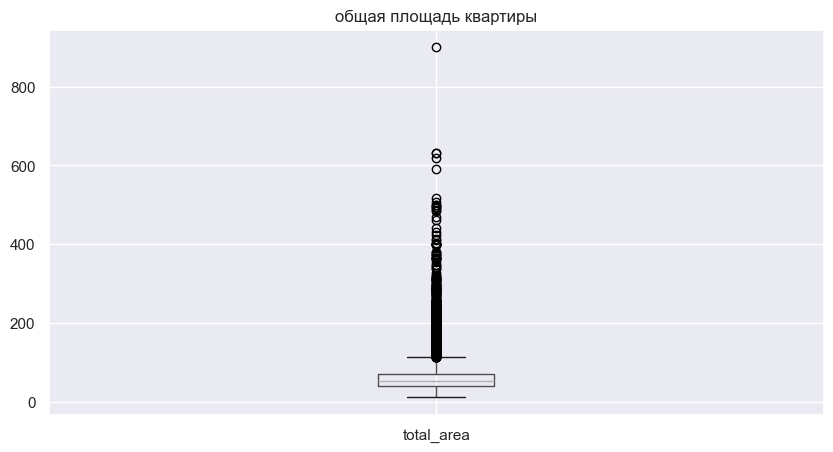

медиана: 52.0 
среднее: 60.3 
min: 12.0 
max: 900.0 
верхний порог выбросов: 114.25 
нижний порог выбросов: -4.55 
Q1: 40.0 
Q3: 69.7


In [37]:
data_boxplot(data, 'total_area', 'общая площадь квартиры')

видим внушительное количество выбросов: все объекты площадью более 114.25 м<sup>2</sup>. так же мы видим, что площадь квартир начинается от 12 м<sup>2</sup>. при том что рекомендуемая минимальная площадь квартиры составляет 28 м<sup>2</sup>. посмотрим, как много в нашем датасете таких квартир:

In [38]:
print(f"количество микроквартир: {len(data.query('total_area < 28'))} \n"
      f"процент от общей выборки: {len(data.query('total_area < 28')) / len(data) * 100} \n \n"
      f"количество больших квартир: {len(data.query('total_area > 114.25'))} \n"
      f"процент от общей выборки: {len(data.query('total_area > 114.25')) / len(data) * 100}"
      )

количество микроквартир: 392 
процент от общей выборки: 1.6575052854122623 
 
количество больших квартир: 1244 
процент от общей выборки: 5.260042283298097


предлагаю оставить микроквартиры в нашем датасете: во-первых, они не являются выбросами, во-вторых, рекомендуемые нормы соблюдаются не всегда: в апартаментах, общежитиях, перестроенных коммуналках и новостройках встречаются квартиры меньшего метража. 

экстремально больших квартир значительно больше: **5.26%** &mdash; однако избавляться от этих строк мы не будем, но запомним срез даных, который нужно получить перед тем как смотреть на корреляцию цены и площади квартиры.

#### 4.1.2 LIVING_AREA

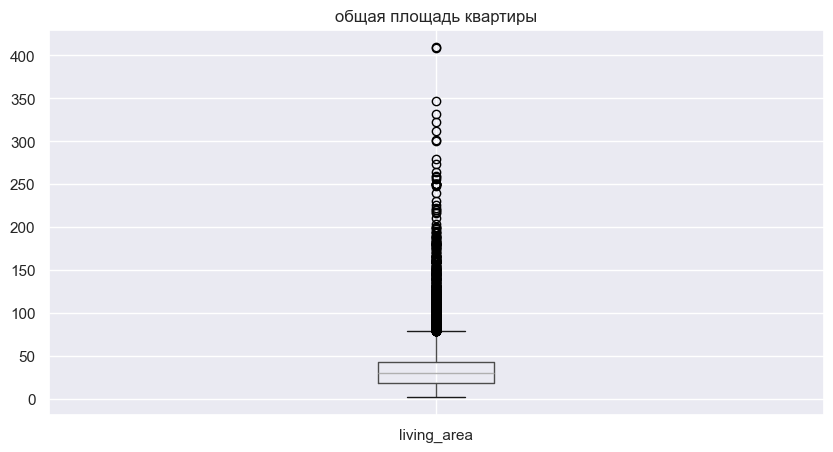

медиана: 30.3 
среднее: 34.3 
min: 2.0 
max: 409.7 
верхний порог выбросов: 79.15 
нижний порог выбросов: -18.05 
Q1: 18.4 
Q3: 42.7


In [39]:
data_boxplot(data, 'living_area', 'общая площадь квартиры')

ранее мы оставили в датасете квартиры с общей площадью 12 - 28 м<sup>2</sup>, допустив, что объекты могут быть микроквартирами. однако даже в случае с экстремально малым метражом жилая площать 2 м<sup>2</sup> кажется недостоверной.  
вооружившись данными об устройстве микроквартир, возьмём минимальную площадь жилого пространства 7 м<sup>2</sup>. посчитаем количество и долю киндидатов на удаление:

In [40]:
print(f"количество микроквартир: {len(data.query('living_area < 7'))} \n"
      f"процент от общей выборки: {len(data.query('living_area < 7')) / len(data) * 100} \n \n"
      f"количество больших квартир: {len(data.query('living_area > 75.75'))} \n"
      f"процент от общей выборки: {len(data.query('living_area > 75.75')) / len(data) * 100}"
      )

количество микроквартир: 8 
процент от общей выборки: 0.03382663847780126 
 
количество больших квартир: 878 
процент от общей выборки: 3.712473572938689


оставим данные на месте, но также как и в предыдущем пункте запомним точки, по которым будем формировать срез для оценки корреляции: `7 <= living_area <= 75.75`

#### 4.1.3 KITCHEN_AREA

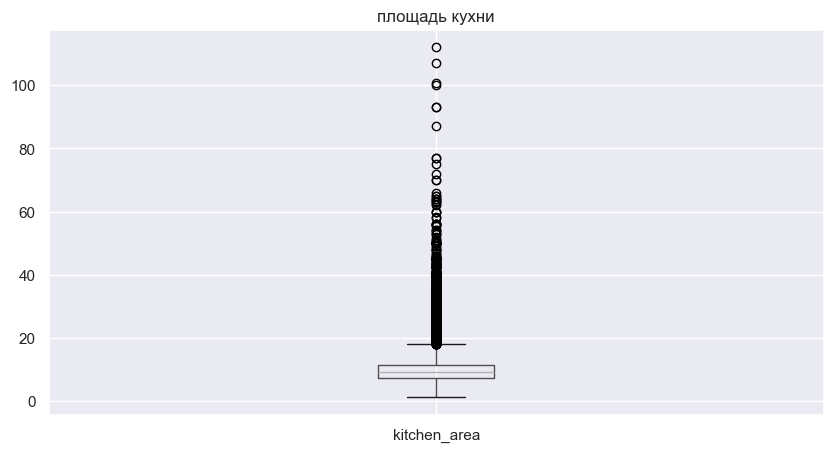

медиана: 9.2 
среднее: 10.5 
min: 1.3 
max: 112.0 
верхний порог выбросов: 18.05 
нижний порог выбросов: 0.85 
Q1: 7.3 
Q3: 11.6


In [41]:
data_boxplot(data, 'kitchen_area', 'площадь кухни')

для данного параметра посмотрим на количество выбросов среди квартир с гигантскими кухнями:

In [42]:
print(f"количество больших кухонь: {len(data.query('kitchen_area > 18.05'))} \n"
      f"процент от общей выборки: {len(data.query('kitchen_area > 18.05')) / len(data) * 100}"
      )

количество больших кухонь: 1461 
процент от общей выборки: 6.177589852008457


перед тем как принимать решение, давайте посмотрим, какова общая площадь таких квартир:

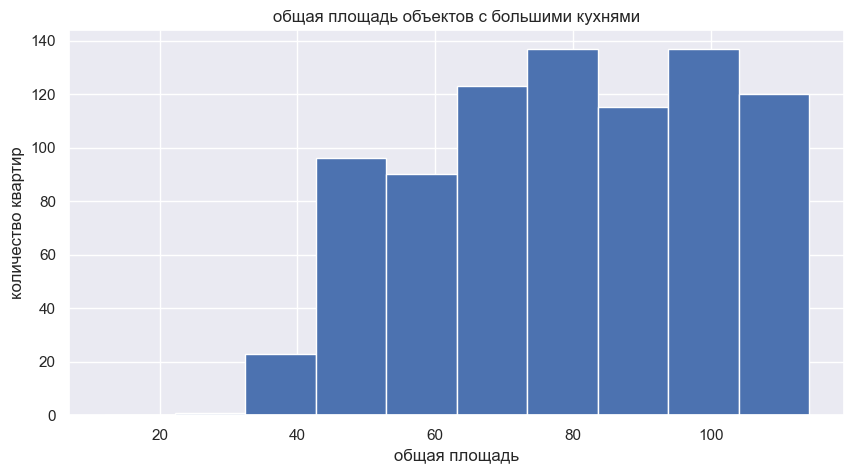

медиана: 105.2 
среднее: 125.0 
порог выбросов: 257.2 
нижний порог выбросов: -33.2


In [43]:
data_big_kitchen = data.query('kitchen_area > 18.05')

data_hist(data_big_kitchen, 'total_area', 'общая площадь объектов с большими кухнями',
         'общая площадь', 'количество квартир', 10, (12, 114.25))

In [44]:
# была идея разбить квартиры с выбросами на группы по возрастанию total area:
# например, в срезе
# data.query('(kitchen_area > 18.05) and ( 40 < total_area < 60)')['kitchen_area']

# заменить выбросы медианным значением для данной группы:
#data.query('40 < total_area < 60')['kitchen_area'].median()

# но я не смогла это провернуть :C

не будем выбрасывать эти наблюдения из датасета, однако отсеим их, когда будем изучать корреляцию цены и площади кухни.

#### 4.1.4 LAST_PRICE

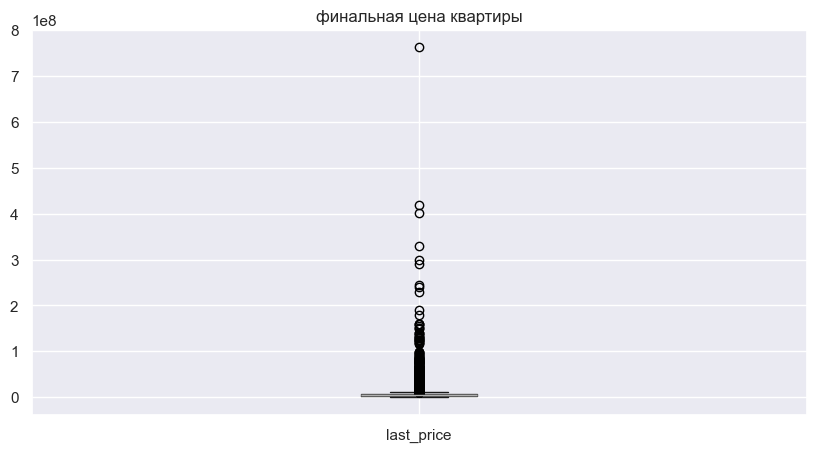

медиана: 4650000.0 
среднее: 6541126.9 
min: 12190.0 
max: 763000000.0 
верхний порог выбросов: 11897500.0 
нижний порог выбросов: -1698500.0 
Q1: 3400000.0 
Q3: 6799000.0


In [45]:
data_boxplot(data, 'last_price', 'финальная цена квартиры')

для данной характеристики посмотрим количество квартир с неоправданно высокими ценами, а также с подозрительно низкими:

In [46]:
print(f"количество слишком дешёвых квартир: {len(data.query('last_price < 500000'))} \n"
      f"процент от общей выборки: {len(data.query('last_price < 500000')) / len(data) * 100} \n \n"
      f"количество слишком дорогих квартир: {len(data.query('last_price > 11897500'))} \n"
      f"процент от общей выборки: {len(data.query('last_price > 11897500')) / len(data) * 100}"
      )

количество слишком дешёвых квартир: 14 
процент от общей выборки: 0.05919661733615222 
 
количество слишком дорогих квартир: 2055 
процент от общей выборки: 8.6892177589852


посмотрим, в каких населённых пунктах находятся квартиры дешевле полумиллиона рублей:

In [47]:
data.query('last_price < 500000').groupby('correct_names')['last_price'].min()

correct_names
Санкт-Петербург                12190.0
Сланцы                        430000.0
городской посёлок Будогощь    450000.0
деревня Вахнова Кара          450000.0
деревня Выскатка              470000.0
деревня Старополье            440000.0
деревня Ям-Тесово             450000.0
посёлок Совхозный             470000.0
посёлок станции Свирь         430000.0
Name: last_price, dtype: float64

из датасета можно исключить квартиру в Санкт-Петербурге за 12190.0: очевидно произошла ошибка при выставлении цены. также исключим неоправданно дорогие квартиры: данный параметр является ключевым и выбросы в нём однозначно повлияют на корреляцию с другими характеристиками квартиры.

In [48]:
data = data.query('12190 < last_price <= 11897500')
print(f"самая дешёвая квартира: {data['last_price'].min()} \n"
      f"самая дорогая квартира: {data['last_price'].max()}")

самая дешёвая квартира: 430000.0 
самая дорогая квартира: 11894400.0


#### 4.1.5 ROOMS

устраняя выбросы среди квартир с экстремально большим метражом и неадекватно большой ценой, мы, скорее всего, избавились от квартир с нестандартно большим количеством комнат. посмотрим, квартиры с каким количеством комнат остались в датасете после предшествующих действий:

rooms
1    7996
2    7584
3    4930
4     754
0     195
5     118
6      16
7       1
Name: count, dtype: int64

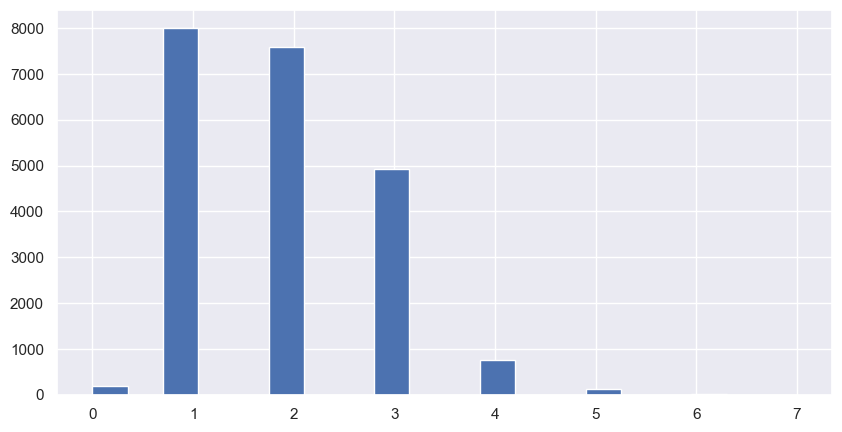

In [49]:
data['rooms'].hist(bins=20)
data['rooms'].value_counts()

распределение данных выглядит адекватно, в текущем датасете большая часть выборки приходится на 1-комнатные и 2-комнатные квартиры. посмотрим на квартиры, в которых 5, 6 и 7 комнат:

In [50]:
data.query('rooms >= 5')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,correct_names,sq_meter_price,weekday,month,year,floor_type,city_center_km
52,20,11795000.0,136.0,2017-09-22,6,3.00,2.0,94.0,2,NaN,...,0.0,NaN,NaN,Санкт-Петербург,86727,4,9,2017,последний,6.6
106,9,10500000.0,124.1,2017-05-25,5,3.20,4.0,79.4,3,NaN,...,0.0,NaN,6.0,Санкт-Петербург,84609,3,5,2017,другой,5.5
201,5,10880000.0,123.1,2015-11-12,6,3.20,5.0,89.0,2,NaN,...,0.0,NaN,992.0,Санкт-Петербург,88383,3,11,2015,другой,3.4
458,9,4200000.0,106.0,2018-10-05,5,NaN,5.0,75.8,1,NaN,...,NaN,NaN,NaN,посёлок городского типа Лебяжье,39622,4,10,2018,первый,NaN
495,1,10400000.0,104.0,2015-09-20,5,3.50,6.0,70.0,4,NaN,...,1.0,145.0,702.0,Санкт-Петербург,100000,6,9,2015,другой,2.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23047,11,10500000.0,110.0,2018-06-30,6,3.20,7.0,75.0,6,NaN,...,0.0,NaN,NaN,Санкт-Петербург,95454,5,6,2018,другой,4.4
23102,0,5800000.0,66.0,2017-06-09,5,NaN,5.0,55.5,1,NaN,...,0.0,NaN,21.0,Санкт-Петербург,87878,4,6,2017,первый,11.9
23305,9,4950000.0,67.0,2018-10-29,5,2.60,5.0,51.2,1,NaN,...,0.0,NaN,89.0,Санкт-Петербург,73880,0,10,2018,первый,12.0
23427,10,7600000.0,104.0,2017-11-28,5,2.87,7.0,69.0,7,NaN,...,1.0,569.0,74.0,Санкт-Петербург,73076,1,11,2017,последний,3.8


с точки зрения количества комнат данные наблюдения являются выбросами, однако, другие характеристики могут пригодиться нам для исследования взаимосвязей. при изучении корреляции цены и количества комнат воспользуемся срезом данных.

теперь посмотрим на 193 объекта, в которых количество комнат равно нулю:

In [51]:
print(f"Как много студий среди квартир с 0 комнат: \n"
      f"{data.query('rooms == 0')['studio'].value_counts()} \n \n"
      f"Какое количество комнат отмечено в квартирах-студиях: \n"
      f"{data.query('studio == True')['rooms'].value_counts()} \n \n"
      f"Общее количество студий в датасете: {len(data.query('studio == True'))}"
     )

Как много студий среди квартир с 0 комнат: 
studio
True     137
False     58
Name: count, dtype: int64 
 
Какое количество комнат отмечено в квартирах-студиях: 
rooms
0    137
1     11
Name: count, dtype: int64 
 
Общее количество студий в датасете: 148


146 человек из датасета честно признались, что их квартира является студией и количество комнат в ней 0. однако нам неизвестно, как много однокомнатных квартир по факту является студиями. чтобы избавиться от выброса, заменим в комнатах все нули на единицы и построим график ещё раз:

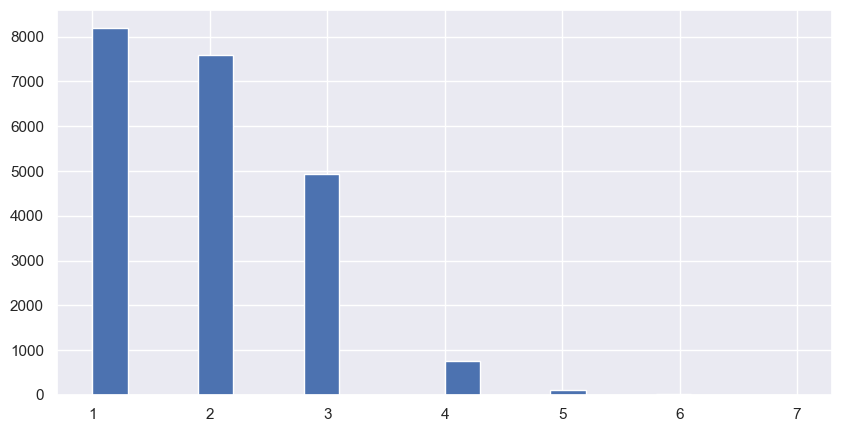

In [52]:
data.loc[data['rooms'] == 0, 'rooms'] = 1
data['rooms'].hist(bins=20)
plt.show()

#### 4.1.6 СEILING_HEIGHT

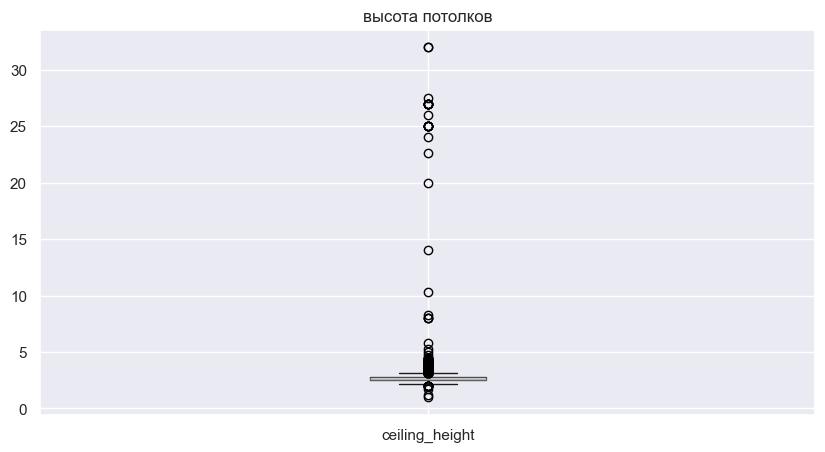

медиана: 2.6 
среднее: 2.7 
min: 1.0 
max: 32.0 
верхний порог выбросов: 3.25 
нижний порог выбросов: 2.05 
Q1: 2.5 
Q3: 2.8


In [53]:
data_boxplot(data, 'ceiling_height', 'высота потолков')

наблюдаем изобилие выбросов по обе стороны усов ящика, сначала обратимся к верхним выбросам. посмотрим на уникальные значения высоты потолков выше 3.25 метра:

In [54]:
data.query('ceiling_height > 3.25')['ceiling_height'].sort_values(ascending=False)

3148     32.00
22336    32.00
21377    27.50
10773    27.00
5246     27.00
         ...  
5190      3.27
7395      3.26
18965     3.26
14701     3.26
14472     3.26
Name: ceiling_height, Length: 405, dtype: float64

самый высокий потолок - 32 метра. очевидно в данном случае при заполнении поля пользователь потерял десятичный знак. найдем значения высоты потолков от 10 метров и поделим их на 10:

In [55]:
data['ceiling_height'] = data['ceiling_height'].apply(lambda x: x/10 if x>=10 else x)

data.query('ceiling_height > 3.24')['ceiling_height'].sort_values(ascending=False)

5863     8.30
17442    8.00
3474     8.00
15743    8.00
21227    5.80
         ... 
4853     3.25
13754    3.25
17936    3.25
3840     3.25
135      3.25
Name: ceiling_height, Length: 410, dtype: float64

чтобы отсеять недостоверные значения, обратимся к историческим данным: в старом фонде Петербурга высота парадных жилых помещений могла достигать 5.1 метра. посмотрим, сколько в датасете наблюдений, выходящих за пределы этой отметки:

In [56]:
data.query('ceiling_height > 5.21')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,correct_names,sq_meter_price,weekday,month,year,floor_type,city_center_km
3474,3,1400000.0,30.0,2018-03-16,1,8.0,5.0,15.3,2,False,...,NaN,NaN,125.0,деревня Нурма,46666,4,3,2018,другой,NaN
5863,20,5650000.0,45.0,2018-08-15,1,8.3,16.0,19.3,14,NaN,...,1.0,613.0,14.0,Санкт-Петербург,125555,2,8,2018,другой,10.8
12628,14,3900000.0,50.0,2018-03-29,1,5.3,5.0,17.6,5,NaN,...,1.0,92.0,8.0,Санкт-Петербург,78000,3,3,2018,последний,3.9
15743,14,5600000.0,67.0,2016-11-11,3,8.0,16.0,41.0,1,NaN,...,0.0,NaN,474.0,Санкт-Петербург,83582,4,11,2016,первый,11.0
17442,0,5350000.0,54.0,2015-06-16,2,8.0,5.0,29.0,2,NaN,...,0.0,NaN,469.0,Красное Село,99074,1,6,2015,другой,28.1
21227,0,8200000.0,71.0,2017-07-21,1,5.8,5.0,68.0,5,NaN,...,3.0,366.0,30.0,Санкт-Петербург,115492,4,7,2017,последний,1.3


всего 6 объектов, и все со странностями:  две квартиры с высотой потолка 8м, находящиеся в 16-этажном доме, один объект, в котором 0 комнат на последнем этаже 5-этажного дома. можно удалить их из датасета.

In [57]:
data = data.query('ceiling_height <= 5.21 or ceiling_height.isna()')

продолжим работу с нижними выбросами: высота потолков ниже установленного минимума (2.5 метра). посмотрим на эти квартиры: 

In [58]:
print(f"доля от общего количества объектов: {len(data.query('ceiling_height < 2.5')) / len(data) * 100} \n \n"
      f"описательная статистика по столбцу: \n{data.query('ceiling_height < 2.5')['ceiling_height'].describe()}"
     )


доля от общего количества объектов: 0.35667963683527887 
 
описательная статистика по столбцу: 
count    77.000000
mean      2.281039
std       0.316521
min       1.000000
25%       2.300000
50%       2.400000
75%       2.450000
max       2.490000
Name: ceiling_height, dtype: float64


всего 77 наблюдений, или **0.61%** от всей выборки. можно удалить данные наблюдения из датасета:

In [59]:
data = data.query('ceiling_height >= 2.5 or ceiling_height.isna()')

#### 4.1.7 FLOORS_TOTAL

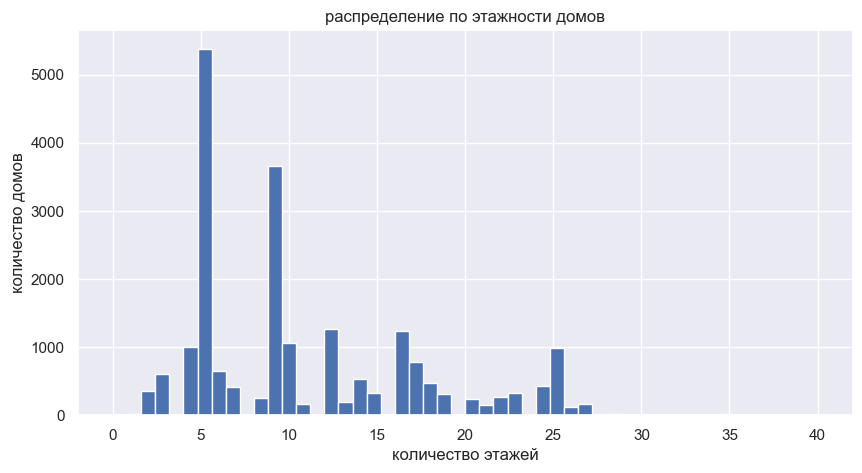

In [60]:
data['floors_total'].hist(bins=50, range=(0, 40))
plt.title('распределение по этажности домов')
plt.xlabel('количество этажей')
plt.ylabel('количество домов')
plt.show()

здания выше 30 этажей можно считать выбросами, посмотрим на этот срез данных перед удалением:

In [61]:
data.query('floors_total > 30')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,correct_names,sq_meter_price,weekday,month,year,floor_type,city_center_km
397,15,5990000.0,54.0,2018-03-22,2,NaN,36.0,21.4,28,NaN,...,3.0,80.0,11.0,Санкт-Петербург,110925,3,3,2018,другой,20.4
871,14,7777777.0,75.0,2017-11-16,2,NaN,35.0,40.5,23,NaN,...,3.0,80.0,169.0,Санкт-Петербург,103703,3,11,2017,другой,20.4
1060,10,5200000.0,50.0,2015-11-06,2,NaN,35.0,39.0,15,False,...,3.0,80.0,281.0,Санкт-Петербург,104000,4,11,2015,другой,20.4
1697,11,3550000.0,28.0,2018-02-08,1,2.65,34.0,18.0,23,NaN,...,3.0,80.0,410.0,Санкт-Петербург,126785,3,2,2018,другой,20.4
1917,13,10150000.0,74.0,2017-11-17,2,2.80,35.0,34.4,30,NaN,...,3.0,80.0,NaN,Санкт-Петербург,137162,4,11,2017,другой,20.4
2253,12,3800000.0,45.5,2018-06-28,2,2.88,60.0,27.4,4,NaN,...,3.0,614.0,166.0,Кронштадт,83516,3,6,2018,другой,49.5
2966,9,4300000.0,37.0,2017-08-08,1,NaN,35.0,14.0,15,NaN,...,3.0,80.0,50.0,Санкт-Петербург,116216,1,8,2017,другой,20.4
4855,12,5500000.0,50.0,2017-06-22,1,2.80,35.0,22.0,4,NaN,...,3.0,145.0,537.0,Санкт-Петербург,110000,3,6,2017,другой,20.3
5749,20,3590000.0,25.0,2017-08-30,1,2.80,35.0,18.0,26,NaN,...,3.0,80.0,198.0,Санкт-Петербург,143600,2,8,2017,другой,20.4
5807,17,8150000.0,80.0,2019-01-09,2,2.70,36.0,41.0,13,NaN,...,3.0,80.0,38.0,Санкт-Петербург,101875,2,1,2019,другой,20.4


все объекты находятся в Петербурге. судя по удалению от центра, это новостройки. объектов немного, однако удалять их не стоит, так как по прочим ключевым параметрам они содержат данные, не являющиеся выбросами. в дальнейшем при определении корреляции между ценой и этажностью дома мы сделаем срез, в котором исключим эти наблюдения.

#### 4.1.8 FLOOR_TYPE

floor_type
другой       15759
последний     2969
первый        2783
Name: count, dtype: int64

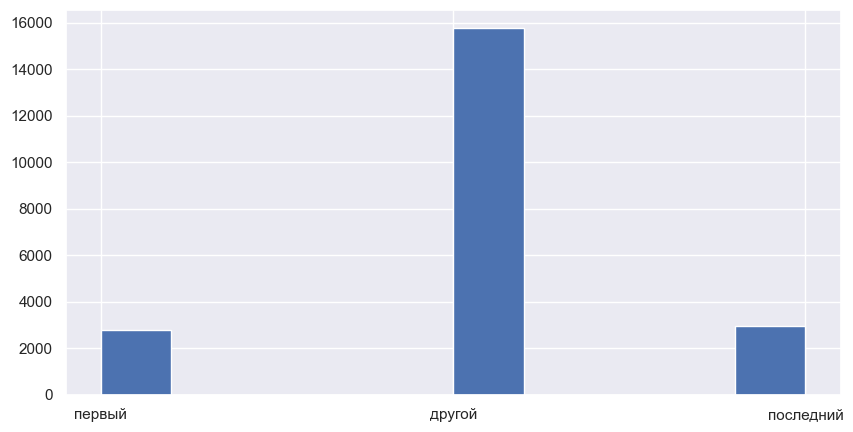

In [62]:
data['floor_type'].hist(bins=10) # т.к. столбец содержит категориальные значения, достаточно будет простой гистограммы.
data['floor_type'].value_counts()

в целом распределение выглядит адекватно: объектов, находящихся не на первом и не на последнем этаже, должно быть значительно меньше. в дальнейшем при изучении корреляции цены и этажности выделим из группы "другой" выборку, которая будет равна по объёму двум другим группам.

#### 4.1.9 CITY_CENTERS_NEAREST

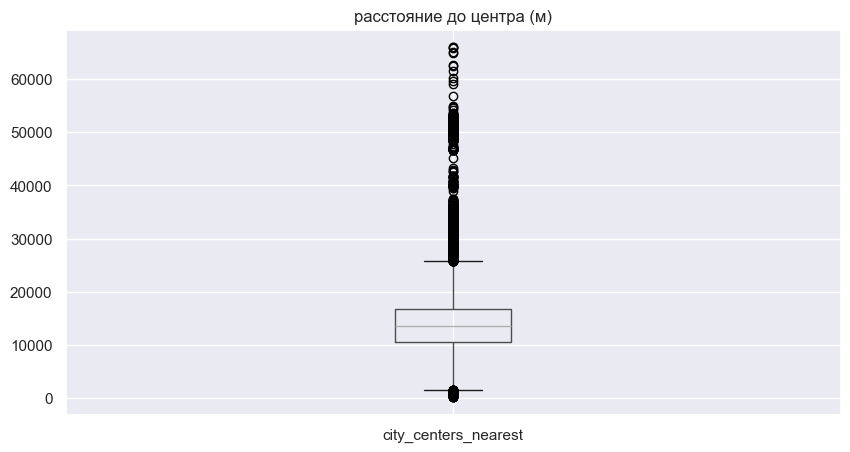

медиана: 13630.0 
среднее: 14986.4 
min: 208.0 
max: 65968.0 
верхний порог выбросов: 25845.75 
нижний порог выбросов: 1511.75 
Q1: 10637.0 
Q3: 16720.5


In [63]:
data_boxplot(data, 'city_centers_nearest', 'расстояние до центра (м)')

посмотрим на данные, являющиеся выбросами по параметру удалённости от центра:

In [64]:
print(f"количество объектов: {len(data.query('city_centers_nearest < 2150 or city_centers_nearest > 25138.8'))} \n"
      f"доля от общего количества объектов: "
      f"{len(data.query('city_centers_nearest < 2150 or city_centers_nearest > 25138.8')) / len(data) * 100} \n"
      )

data.query('city_centers_nearest < 2150 or city_centers_nearest > 25138.8')

количество объектов: 2069 
доля от общего количества объектов: 9.618334805448375 



,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,correct_names,sq_meter_price,weekday,month,year,floor_type,city_center_km
11,9,3300000.0,44.0,2018-08-27,2,NaN,5.0,31.0,4,False,...,0.0,NaN,7.0,Ломоносов,75000,0,8,2018,другой,51.7
13,20,3550000.0,42.8,2017-07-01,2,2.56,5.0,27.0,5,NaN,...,3.0,298.0,366.0,Петергоф,82943,5,7,2017,последний,33.1
14,1,4400000.0,36.0,2016-06-23,1,NaN,6.0,17.0,1,NaN,...,1.0,96.0,203.0,Пушкин,122222,3,6,2016,первый,30.8
28,8,4170000.0,44.0,2017-12-13,1,2.90,6.0,20.8,1,NaN,...,1.0,118.0,74.0,Пушкин,94772,2,12,2017,первый,30.7
33,8,4800000.0,73.0,2018-10-15,4,NaN,9.0,51.6,5,NaN,...,0.0,NaN,92.0,Колпино,65753,0,10,2018,другой,32.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23667,14,9990000.0,90.0,2017-01-23,3,3.06,17.0,55.0,9,False,...,1.0,545.0,86.0,Сестрорецк,111000,0,1,2017,другой,33.3
23669,8,3000000.0,34.1,2017-11-10,1,NaN,9.0,17.0,3,NaN,...,1.0,741.0,74.0,Колпино,87976,4,11,2017,другой,30.5
23678,10,3500000.0,43.0,2016-05-19,2,2.50,3.0,26.1,2,False,...,1.0,1134.0,252.0,Пушкин,81395,3,5,2016,другой,28.0
23685,15,2490000.0,31.0,2019-01-24,1,2.50,5.0,17.3,5,NaN,...,0.0,NaN,NaN,Ломоносов,80322,3,1,2019,последний,51.8


не хочется безвозвраьно терять **10.1%** выборки при том, что объекты, в ней представленные, не являются выбросами по другим ключевым показателям. поэтому, анализируя связь между ценой и удалённостью от города, мы просто воспользуемся срезом.

#### 4.1.10 PARKS_NEAREST

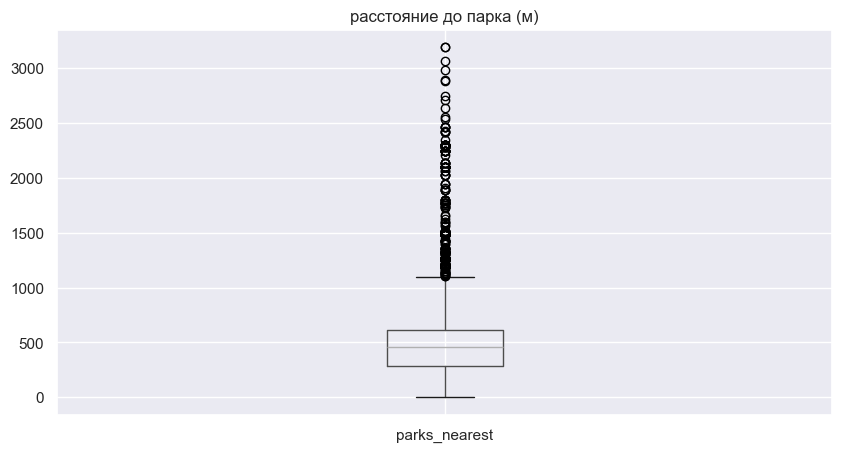

медиана: 455.0 
среднее: 487.7 
min: 1.0 
max: 3190.0 
верхний порог выбросов: 1100.5 
нижний порог выбросов: -199.5 
Q1: 288.0 
Q3: 613.0


In [65]:
data_boxplot(data, 'parks_nearest', 'расстояние до парка (м)')

In [66]:
print(f"количество объектов: {len(data.query('parks_nearest > 1079.5'))} \n"
      f"доля от общего количества объектов: "
      f"{len(data.query('parks_nearest > 1079.5')) / len(data) * 100} \n"
      )

data.query('parks_nearest > 1079.5')

количество объектов: 253 
доля от общего количества объектов: 1.1761424387522663 



,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,correct_names,sq_meter_price,weekday,month,year,floor_type,city_center_km
195,8,5300000.0,60.0,2016-05-19,3,NaN,9.0,45.00,4,NaN,...,3.0,239.0,372.0,Санкт-Петербург,88333,3,5,2016,другой,17.1
196,7,8715960.0,57.0,2017-06-29,1,NaN,5.0,20.00,5,NaN,...,2.0,97.0,119.0,Санкт-Петербург,152911,3,6,2017,последний,16.5
323,6,9591727.0,72.0,2017-06-29,2,2.80,10.0,34.00,9,NaN,...,1.0,534.0,118.0,Санкт-Петербург,133218,3,6,2017,другой,5.4
371,11,7300000.0,65.0,2018-09-12,2,NaN,12.0,30.04,2,NaN,...,2.0,372.0,92.0,Санкт-Петербург,112307,2,9,2018,другой,17.6
438,6,7410000.0,70.0,2017-06-29,2,NaN,12.0,30.50,5,NaN,...,1.0,534.0,229.0,Санкт-Петербург,105857,3,6,2017,другой,5.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22870,13,9800000.0,88.7,2018-10-04,3,2.80,12.0,49.00,7,NaN,...,2.0,480.0,60.0,Санкт-Петербург,110484,3,10,2018,другой,7.6
23080,15,4650000.0,44.5,2018-02-20,2,NaN,5.0,25.20,2,NaN,...,1.0,284.0,152.0,Санкт-Петербург,104494,1,2,2018,другой,9.9
23159,2,7952000.0,64.0,2018-07-05,2,2.75,10.0,37.00,3,NaN,...,1.0,534.0,54.0,Санкт-Петербург,124250,3,7,2018,другой,5.4
23426,17,8778000.0,47.5,2014-12-29,1,3.00,7.0,17.60,4,NaN,...,3.0,204.0,1360.0,Санкт-Петербург,184800,0,12,2014,другой,10.2


253 объекта (1% наблюдений) являются выбросами только для этой характеристики. так же, как и в случае с расстоянием до центра, мы не будем удалять эти объекты и в дальнейшем воспользуемся срезом.  

### 4.2 Скорость продажи квартиры

сколько времени нужно, чтобы продать квартиру? чтобы представить общую картину, визуализируем распределение на графике:

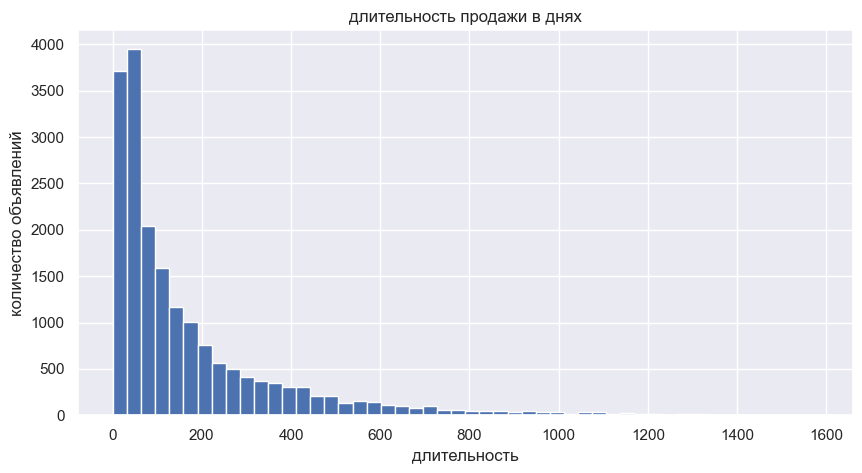

медиана: 91.0 
среднее: 173.2 
порог выбросов: 481.5 
нижний порог выбросов: -218.5


In [67]:
data_hist(data, 'days_exposition', 
          'длительность продажи в днях', 
          'длительность', 'количество объявлений',
          50, (data['days_exposition'].min(), data['days_exposition'].max()))

объявления, активные более 480 дней - выбросы. либо их забыли своевременно снять с продажи, либо это "трудные" квартиры (слишком высокая цена, неудачное расположение, недостаток информации о квартире). возьмём соответствующий срез данных:

In [68]:
data.query('days_exposition > 480')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,correct_names,sq_meter_price,weekday,month,year,floor_type,city_center_km
2,10,5196000.0,56.00,2015-08-20,2,NaN,5.0,34.3,4,NaN,...,2.0,574.0,558.0,Санкт-Петербург,92785,3,8,2015,другой,13.9
17,6,4180000.0,36.00,2016-09-09,1,NaN,17.0,16.5,7,NaN,...,1.0,859.0,571.0,Санкт-Петербург,116111,4,9,2016,другой,14.6
23,11,2950000.0,32.00,2016-10-29,1,2.60,9.0,17.7,9,NaN,...,1.0,190.0,615.0,Санкт-Петербург,92187,5,10,2016,последний,14.2
43,13,9330000.0,48.00,2017-01-10,2,3.00,4.0,28.0,4,NaN,...,1.0,492.0,763.0,Санкт-Петербург,194375,1,1,2017,последний,10.8
61,18,7990000.0,74.00,2017-08-24,2,NaN,4.0,43.0,4,NaN,...,0.0,NaN,609.0,Санкт-Петербург,107972,3,8,2017,последний,4.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23664,5,9000000.0,110.00,2015-12-10,4,3.36,7.0,64.6,5,NaN,...,1.0,118.0,816.0,Санкт-Петербург,81818,3,12,2015,другой,5.0
23672,5,3000000.0,30.80,2016-06-08,1,NaN,5.0,16.1,3,NaN,...,0.0,NaN,808.0,Санкт-Петербург,97402,2,6,2016,другой,14.2
23675,8,3550000.0,39.50,2016-10-03,1,NaN,16.0,19.0,13,NaN,...,0.0,NaN,721.0,Санкт-Петербург,89873,0,10,2016,другой,15.0
23691,11,9470000.0,72.90,2016-10-13,2,2.75,25.0,40.3,7,NaN,...,1.0,806.0,519.0,Санкт-Петербург,129903,3,10,2016,другой,4.5


1599 объектов из 23699 продавались боле 480 дней - это 6.7% выборки. отбрасывать эти строки мы не будем, но запомним эту метку. перед тем как строить ящик с усами, укрупним график, чтобы посмотреть, как выглядит распределение выбросов:

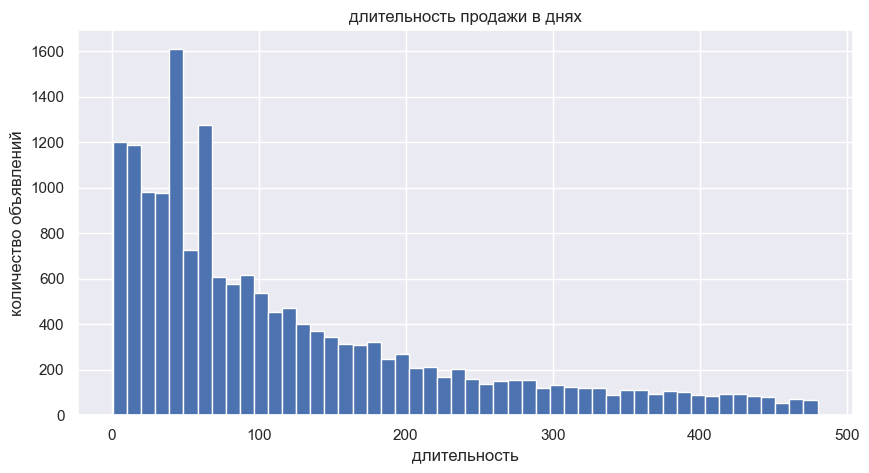

медиана: 79.0 
среднее: 121.5 
порог выбросов: 376.5 
нижний порог выбросов: -163.5


In [69]:
data_expo = data.query('days_exposition <= 480') # создадим вспомогательный датасет, который передадим в функцию.

data_hist(data_expo, 'days_exposition', 
          'длительность продажи в днях', 
          'длительность', 'количество объявлений',
          50, (data_expo['days_exposition'].min(), 480))

со стороны быстрых продаж наблюдается два пика, один из которых подозрительно близок к нулю. давайте рассмотрим более детально левую часть графика, ограничив его медианным значением:

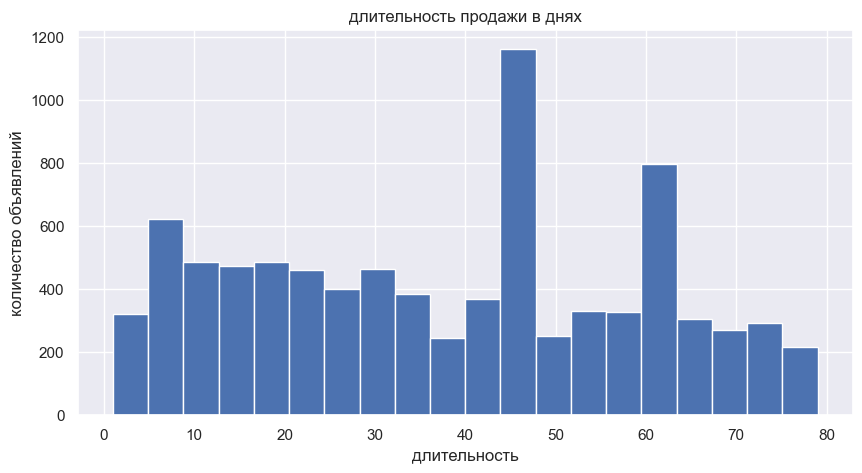

медиана: 79.0 
среднее: 121.5 
порог выбросов: 376.5 
нижний порог выбросов: -163.5


In [70]:
data_hist(data_expo, 'days_exposition', 
          'длительность продажи в днях', 
          'длительность', 'количество объявлений',
          20, (data_expo['days_exposition'].min(), 79))

на укрупнённом графике видны всплески по длительности продаж в районе 45 дней и в районе 60 дней. это можно объяснить автоматизацией удаления объявлений: по правилам сервиса установлен разный срок размещения объявления в зависимости от стоимости объекта: 45, 60 и 90 дней &mdash; чем дороже недвижимость, тем больше времени выделяется на её продажу.  

для оценки быстрых продаж построим ящик с усами: всё, что между Q1 и нижней границей выброса будем принимать за слишком быстрые продажи, всё, что между Q3 и верхним порогом &mdash; за слишком медленные.

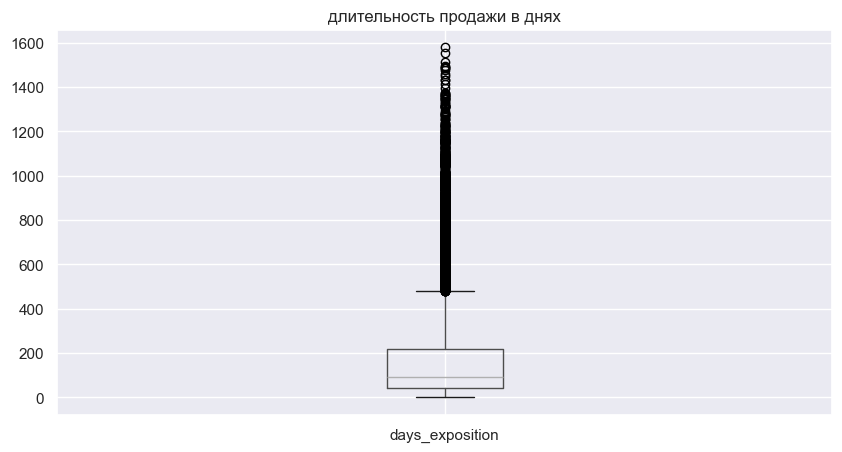

медиана: 91.0 
среднее: 173.2 
min: 1.0 
max: 1580.0 
верхний порог выбросов: 481.5 
нижний порог выбросов: -218.5 
Q1: 44.0 
Q3: 219.0


In [71]:
data_boxplot (data, 'days_exposition', 'длительность продажи в днях')

In [72]:
# создадим два датасета для хранения медианных показателей для разных групп: super_fast и normal:

super_fast = (data.query('days_exposition < 44 and locality_name == "Санкт-Петербург"')
.pivot_table(index='days_exposition', 
            values=['last_price', 'city_center_km', 'total_area', 'total_images', 'month'],
            aggfunc=['median'])
.reset_index()
             )
              
normal = (data.query('44 <= days_exposition <= 219 and locality_name == "Санкт-Петербург"')
.pivot_table(index='days_exposition', 
            values=['last_price', 'city_center_km', 'total_area', 'total_images', 'month'],
            aggfunc=['median'])
.reset_index()
)

# объединим датасеты в один, чтобы сравнить показатели:
norm_vs_fast = pd.concat([super_fast, normal], axis='columns')
norm_vs_fast.head(15)

days_exposition         median                                           \
                   city_center_km last_price month total_area total_images   
0              1.0          14.40  4000000.0   5.0       49.9         19.0   
1              2.0          10.30  6100000.0   4.0       45.1          4.0   
2              3.0          12.30  4550000.0   8.0       45.5         10.0   
3              4.0          12.40  4700000.0   7.0       50.4          7.0   
4              5.0          12.55  4500000.0   6.0       46.6          9.0   
5              6.0          12.70  4515000.0   8.0       46.0         10.5   
6              7.0          13.10  4800000.0   7.0       45.0          9.0   
7              8.0          13.40  4500000.0   8.0       44.0         10.0   
8              9.0          12.80  4390000.0   7.0       44.1          9.0   
9             10.0          13.20  4550000.0   8.0       45.0         10.0   
10            11.0          12.90  5000000.0   8.0       48.2          9.0   
11            12.0          12.30  4700000.0   9.0       45.5          9.0   
12            13.0          13.05  4725000.0   7.0       49.0          9.5   
13            14.0          13.20  4950000.0   7.0       49.3          9.0   
14            15.0          12.70  4960000.0   6.0       46.0          9.0   

   days_exposition         median                                           
                   city_center_km last_price month total_area total_images  
0             44.0          13.40  4150000.0   7.0      44.00          7.0  
1             45.0          13.70  3850000.0   6.0      40.00          7.0  
2             46.0          13.40  4212500.0   7.0      39.80         10.0  
3             47.0          13.15  4820000.0   6.5      47.35          9.0  
4             48.0          12.70  4990000.0   8.0      48.30         10.0  
5             49.0          13.10  4650000.0   7.0      46.50         11.0  
6             50.0          13.40  4500000.0   8.0      45.00         12.0  
7             51.0          12.00  4425000.0   9.0      46.75         10.5  
8             52.0          12.60  4699500.0   7.5      46.00         11.0  
9             53.0          12.30  5300000.0   8.0      50.00          9.0  
10            54.0          14.80  4950000.0   6.0      51.40          9.0  
11            55.0          12.70  5000000.0   9.0      50.00         12.0  
12            56.0          14.20  4800000.0   8.0      45.00         10.0  
13            57.0          14.10  4600000.0   7.0      47.10          7.0  
14            58.0          13.65  6000000.0   6.0      59.25          9.5

в целом быстро уходят с продажи квартиры, для которых характерна более низкая цена при такой же, либо меньшей удалённости от центра. 

прежде чем перейти к следующему этапу исследования, давайте оценим потери: сколько строк было в датасете на старте и сколько мы имеем сейчас, после работы с пропусками, дубликатами и выбросами.

In [73]:
missing_data_final = data.isna().sum().to_frame().rename(columns = {0: 'missing_values_final'})

# соберём статистику по доле пропусков посде работы с выбросами и пропусками:
missing_data_final['total_values_final'] = data.shape[0]
missing_data_final['% of total_final'] = (missing_data_final['missing_values_final'] / data.shape[0] * 100).round(2)

# добавим столбец с разницей между долей пропусков на старте и на данный момент:
missing_data_final['% of total_compare'] = (missing_data_start['% of total_start'] - 
                                           missing_data_final['% of total_final'])

# добавим столбец с долей данных, утраченных в ходе предобработки:
missing_data_final['total_compare'] = (((23699 - missing_data_final['total_values_final']) / 23699 * 100).round(2))

missing_data_final.sort_values('% of total_compare', ascending=False)

,missing_values_final,total_values_final,% of total_final,% of total_compare,total_compare
balcony,0,21511,0.00,48.61,9.23
kitchen_area,0,21511,0.00,9.61,9.23
living_area,0,21511,0.00,8.03,9.23
days_exposition,2626,21511,12.21,1.21,9.23
locality_name,0,21511,0.00,0.21,9.23
floors_total,73,21511,0.34,0.02,9.23
studio,0,21511,0.00,0.00,9.23
last_price,0,21511,0.00,0.00,9.23
total_images,0,21511,0.00,0.00,9.23
floor,0,21511,0.00,0.00,9.23


### Промежуточный итог
в ходе предобработки данных удалось сократить количество пропусков в разных столбцах от **0.21%** до **48.61%**.  
в ходе работы с выбросами нам пришлось отказаться от **9.23%** данных. чтобы сохранить как можно больше полезных данных, было принято решение отсекать от основного датасета только те наблюдения, в которых есть выбросы либо по ключевым показателями (цена объекта), либо выбросы, сочетающиеся со странным наполнением остальных характеристик объекта (высота потолков). во всех остальных случаях при определении корреляции будем пользоваться срезами данных.

### 4.3 Факторы, влияющие на стоимость объекта 
в следующем шаге мы проверим, какие факторы могут оказывать влияние на стоимость объекта. изучим, насколько цена чувствительна к следующим характеристикам:
- `total_area` &mdash; общая площадь
- `living_area` &mdash; жилая площадь
- `kitchen_area` &mdash; площадь кухни
- `rooms` &mdash; количество комнат
- `floor_type` &mdash; тип этажа (первый, последний, другой)
- `weekday`, `month`, `year` &mdash; день, неделя и год публикации объявления

**корреляция: цена &mdash; общая площадь**

перед тем как построить график, сделаем срез по значению `total_area` < 114.25.

Корреляция: 0.69


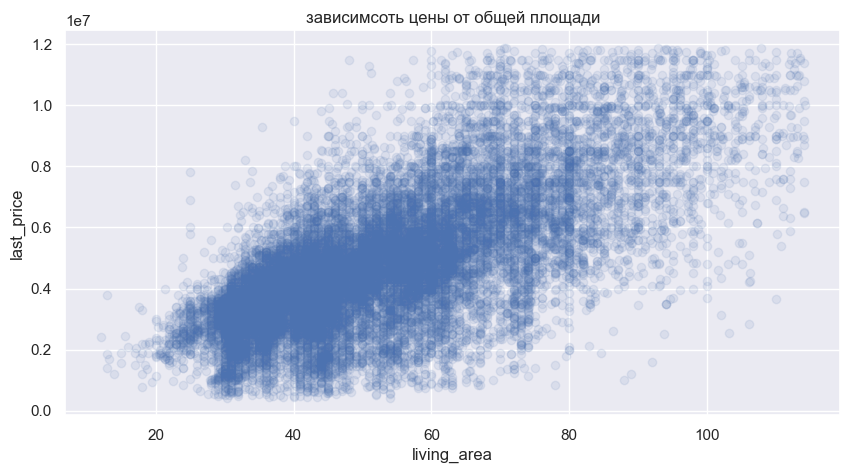

In [74]:
data_scatter(data.query('total_area < 114.25')['total_area'], 
             data.query('total_area < 114.25')['last_price'],
             'зависимсоть цены от общей площади', 
             'living_area', 'last_price', 0.1)

уровень корреляциии приемлемый: чем больше общая площать, тем выше цена. отсутствие ярко выраженной линейной зависимости свидетельствует о влиянии смежных факторов, например, расположение квартиры (важен район города и, в случае Петербурга, удалённость от станций метро).

**корреляция: цена &mdash; жилая площадь**

в ходе предобработки данных из столбца `living_area`, так же как и из `last_price` были удалены экстремальные значения. посмотрим на корреляцию этих двух характеристик.

Корреляция: 0.55


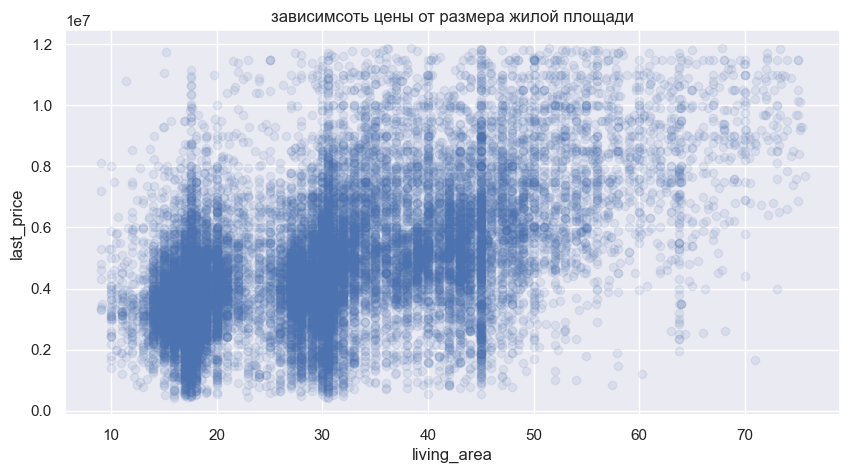

In [75]:
data_scatter(data.query('9 <= living_area <= 75.75')['living_area'], 
             data.query('9 <= living_area <= 75.75')['last_price'], 
             'зависимсоть цены от размера жилой площади', 
             'living_area', 'last_price', 0.1)

здесь уровень корреляции уже ниже, что можно объяснить, во-первых, влиянием сопутствующих факторов, а также наличием пропусков и выбросов в исходном датасете.

**корреляция: цена &mdash; площадь кухни**  
напомним, что на этапе работы с выбросами мы решили не отсекать их от общей выборки, но перед построением графика взять срез данных по количеству комнат:

Корреляция: 0.47


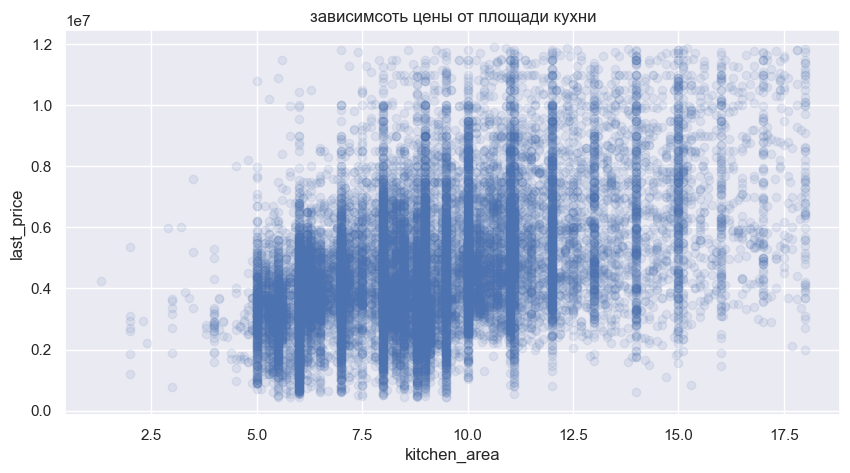

In [76]:
data_scatter(data.query('kitchen_area <= 18.05')['kitchen_area'], 
             data.query('kitchen_area <= 18.05')['last_price'],
             'зависимсоть цены от площади кухни', 
             'kitchen_area', 'last_price', 0.1)

уровень корреляции ещё ниже: **0.47%** 
контрастные "столбы", проступающие через общую массу наблюдений &mdash; скорее всего, след нашего заполнения пропусков типовыми значениями. в целом наблюдается неярко выраженная корреляция между площалью кухни и стоимостью объекта, в чём есть логика: как правило, чем больше общая площадь квартиры, тем больше площади отводится под кухню.  

**корреляция: цена &mdash; количество комнат**  
в данном случае мы также используем срез данных, отсекающих выбросы из датасета: включим в график только квартиры-студии, а также квартиры с 1-4 комнатами.

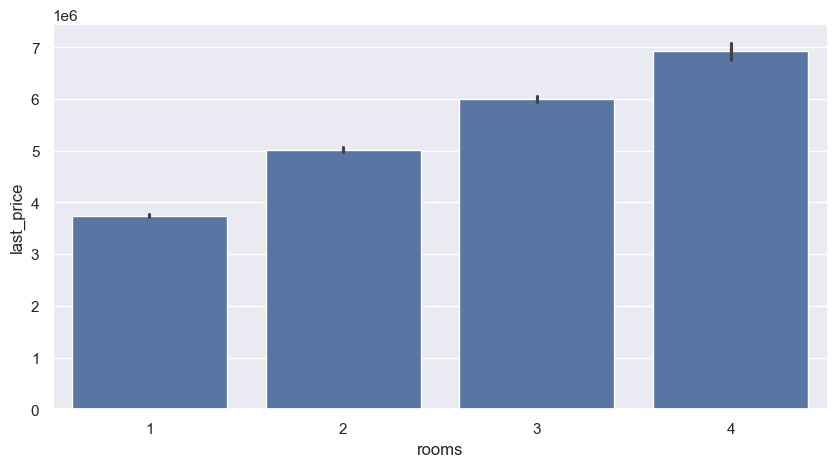

In [77]:
sns.barplot(data=data.query('rooms < 5'), x='rooms', y='last_price')
sns.set(font_scale=1.2)
plt.show()

график подсвечивает печальный факт: чем больше в квартире комнат, тем дороже она нам обойдётся. при этом разница в цене незначительно уменьшается с увеличением комнат: ценовой разрыв между 1-комнатной квартирой и 2-комнатной больше, чем между 2-комнатной и 3-комнатной. посмотрим на разницу медианных показателей:

In [78]:
for i in range(1, 5):
    if i == 1:
        pass
    else:
        print(f"Разница между {i-1}-к.кв. и {i}-к.кв.: "
              f"{data.query('rooms == @i')['last_price'].median() - data.query('rooms == @i-1')['last_price'].median()}"
             )

    

Разница между 1-к.кв. и 2-к.кв.: 1110000.0
Разница между 2-к.кв. и 3-к.кв.: 1020000.0
Разница между 3-к.кв. и 4-к.кв.: 1250000.0


**корреляция: цена &mdash; день недели**

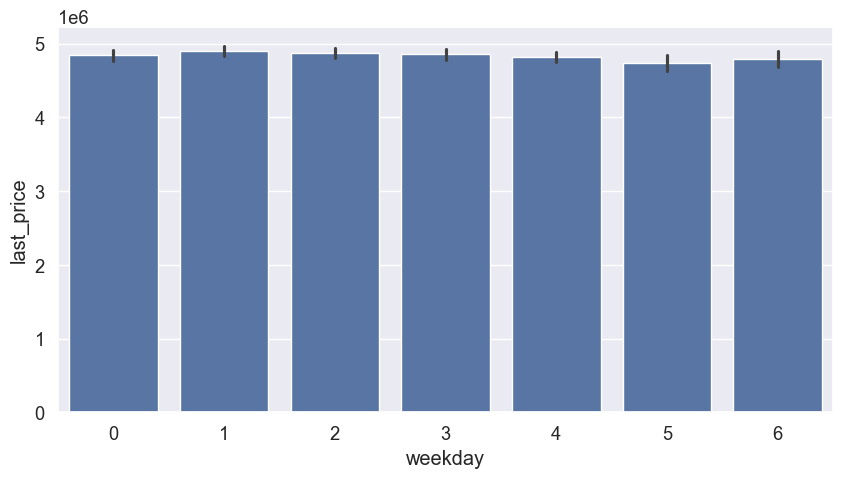

In [79]:
sns.barplot(data=data, x='weekday', y='last_price')
sns.set(font_scale=1.2)
plt.show()

напомним, что дни недели у нас закодированы от нуля и до шести, где ноль &mdash; это понедельник.  
ожидаемо нет особой корреляции между днём недели и стоимостью квартиры. в субботу и воскресенье люди готовы продешевить, но это неточно (:  

**корреляция: цена — месяц**

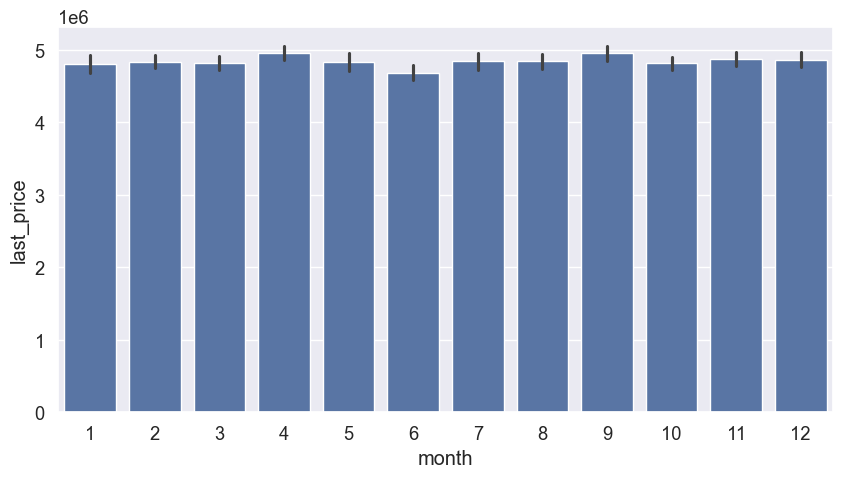

In [80]:
sns.barplot(data=data, x='month', y='last_price')
sns.set(font_scale=1.2)
plt.show()

здесь наблюдается чуть более живая динамика, однако в нашем датасете собраны данные только за 6 лет: то есть всего 6 комплектов данных для каждого месяца. в данном случае мы не можем проверить предположение, что месяц старта продаж действительно не оказывает влияния на цену квартиры.  

**корреляция: цена — год**

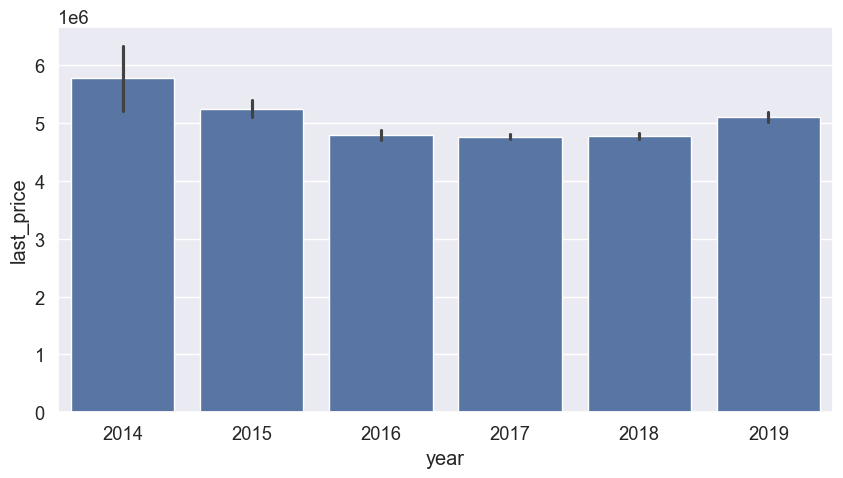

In [81]:
sns.barplot(data=data, x='year', y='last_price')
sns.set(font_scale=1.2)
plt.show()

здесь явно прослеживается динамика на постепенное уменьшение с последующей стабилизацией цены, однако в данном случае следует учитывать внешние факторы, не отображённые в датасете. например, долю первичного жилья на рынке недвижимости, общую экономическую ситуацию в стране, кредитные программы банков и так далее. 

прежде чем перейти к промежуточным итогам, проверим ещё один фактор, оказывающий влияние на образование цены: этаж, на котором расположена квартира. как мы помним, количество квартир с типом этажа "другой" почти в пять раз превышает количество квартир остальных категорий в общей выборке. посмотрим на соотношение групп в Петербурге, на который приходится наибольшее количество объявлений:

In [82]:
data.query('locality_name == "Санкт-Петербург"')['floor_type'].value_counts()

floor_type
другой       10630
последний     1572
первый        1493
Name: count, dtype: int64

для Петербурга разрыв в группах ещё сильнее: более, чем в 6 раз. чтобы сформировать три примерно равные подвыборки, случайным образом выберем 970 квартир Петербурга с типом этажа "другой":

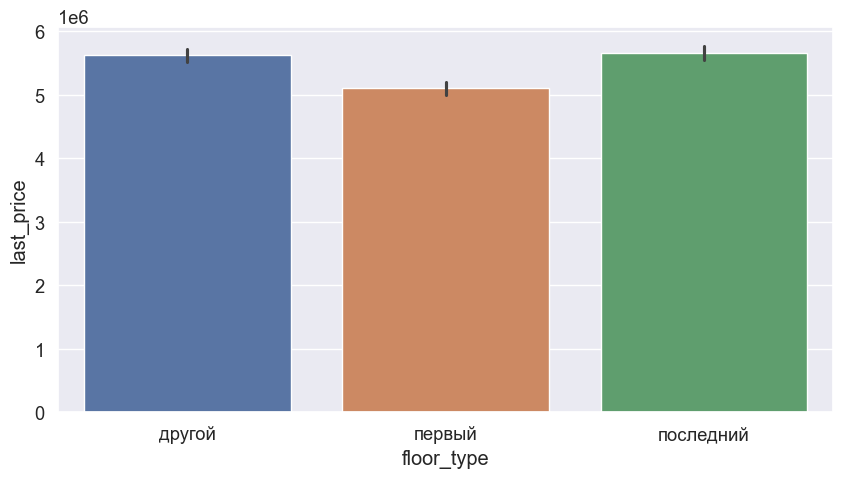

In [87]:
other_floor = data.query('floor_type == "другой" and locality_name == "Санкт-Петербург"').sample(n=1500)

equal_groups = pd.concat([other_floor, 
                          data.query('floor_type != "другой" and locality_name == "Санкт-Петербург"')], 
                         ignore_index=True)

sns.barplot(data=equal_groups, x='floor_type', y='last_price', hue='floor_type')
sns.set(font_scale=1.2)
plt.show()

на сравнении трёх примерно равных подвыборок мы убедились в том, что квартиры с типом этажа "другой" почти на полмиллиона дороже квартир на первом этаже и в меньшей степени дороже квартир на последнем этаже.

### Промежуточный итог
в результате исследовательского анализа данных была обнаружена корреляция между ценой и общей площадью квартиры, этажом квартиры, а так же между ценой и количеством комнат. при этом ценовой разрыв между одной и двумя комнатами в квартире больше, чем разница цен между квартирами с двумя и тремя комнатами.

зависимость цены от жилой площади и площади кухни выражена в меньшей степени. есть предположение, что на более чистых данных эта зависимость будет выражена ярче. для проверки гипотезы нужно дополнительное исследование. также требует дополнительного исследования на данных за больший период зависимость между ценой и месяцем выставления квартиры на продажу.

отсутствует корреляция между ценой и днём публикации объявления.

### 4.4 Расчёт средней стоимости квадратного метра

для расчёта средней стоимости квадратного метра возьмём 10 населённых пунктов с самым большим количеством объявлений и узнаем среднюю стоимость этого показателя для каждого города из топ-10. города с меньшим количеством объявлений не будем принимать в рассчёт: чем меньше наблюдений, тем менее репрезентативна подвыборка.

In [84]:
main_cities = (data['correct_names'].value_counts() # посчитаем количество объявлений для каждого города
               .head(10)                            # возмём первые 10 позиций
               .index.values.tolist()               # и завернём в список индексы, содержащие названия городов
              )

(data.query("correct_names in @main_cities")        # сделаем срез датасета по городам из списка топ-10
 .pivot_table(index='correct_names',                # сформируем сводную таблицу, назначив строками города 
              values='sq_meter_price',              # и для каждого рассчитаем цену квадратного метра 
              aggfunc=['count', 'mean'])            # усреднённую по заданному города
 .sort_values(('mean','sq_meter_price'), ascending=False)     # отсортируем строки по убыванию цены квадратного метра
 .round(1)                                                    # и срежем знаки после запятой до десятых.
)

,count,mean
,sq_meter_price,sq_meter_price
correct_names,,
Санкт-Петербург,13695,105446.4
Пушкин,335,100288.8
Кудрово,469,95152.5
посёлок Парголово,326,90205.0
Мурино,590,86087.1
посёлок Шушары,440,78676.9
Колпино,335,75203.8
Гатчина,305,68421.5


дороже всего квадратный метр обходится жителям Петербурга, что вполне ожидаемо, в то время как самым недорогим из первой десятки оказался Выборг.  
так как в задачу данного исследования не входит анализ причин и прогнозирование возможного колебания цен в рамках отдельного города, сейчас мы не можем ответить на вопрос, по каким причинам цены за квадратный метр в разных региональных городах распределились таким оборазом.

### 4.5 Стоимость квартиры и удалённость от центра

посмотрим, как сказывается на стоимости квадратного метра удалённость от центра. скорее всего, зависимость обратная: чем дальше, тем дешевле. однако стоит визуализировать это предположение сначала в цифрах, потом в графике. с каждым шагом будем уходить от центра на километр.

In [85]:
data['city_center_km'] = data['city_center_km'].round() # сначала округдлим расстояние до целых.

price_per_km = (data.query('locality_name == "Санкт-Петербург"') # возьмём срез данных по Петербургу
                .pivot_table(index='city_center_km',             # составим сводную таблицу, назначив строками расстояние
                             values='last_price',                # для каждой строки рассчитаем среднюю цену
                             aggfunc='mean')
                .reset_index()
               )
# для удобства восприятия зададим сокращённую цену:
price_per_km['last_price_mil'] = price_per_km['last_price'] / 1000000
price_per_km['city_center_km'] = price_per_km['city_center_km'].astype('int')
price_per_km

,city_center_km,last_price,last_price_mil
0,0,8.498182e+06,8.498182
1,1,8.187725e+06,8.187725
2,2,7.941600e+06,7.941600
3,3,7.366598e+06,7.366598
4,4,7.610582e+06,7.610582
5,5,7.670234e+06,7.670234
6,6,7.123484e+06,7.123484
7,7,6.681622e+06,6.681622
8,8,6.519964e+06,6.519964
9,9,5.602452e+06,5.602452


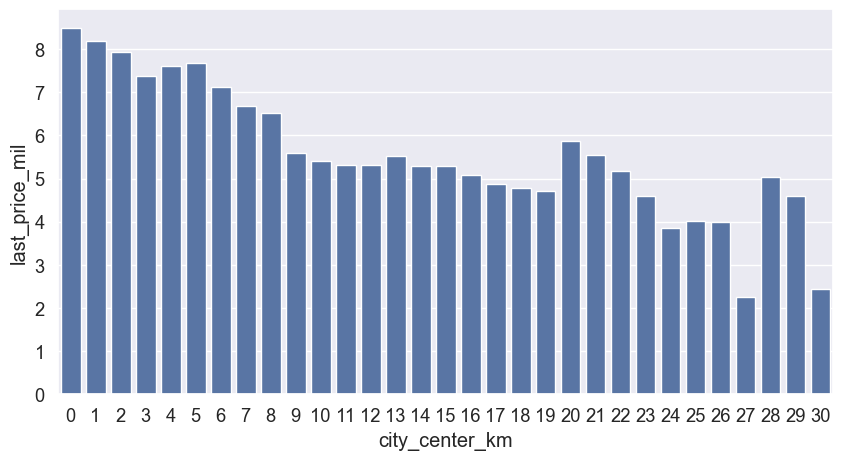

In [86]:
sns.barplot(data=price_per_km, x='city_center_km', y='last_price_mil')
plt.show()

в целом гипотеза подтверждается, однако линейной зависимости здесь нет, что легко объяснить влиянием смежных факторов, не учтённых в нашем датасете. например, помимо расстояния от центра важным фактором является близость к станциям метро, а также благоустроенность района, в котором находится квартира (озеленение, качество инфраструктуры, доступная среда, детские сады, школы и поликлиники и т.д).

### 5. Общие выводы

в результате исследовательского анализа данных мы определили, насколько сильно различные показатели влияют на цену квартир в Петербурге и близлежащих городах. средняя стоимость квадратного метра в Петербурге в период, охватываемый данными, составляет 105 364 рубля. самым доступным среди городов с наибольшим количеством объявлкний оказался Выборг: 58 027 рубля за квадратный метр. цена формируется под влиянием следующих факторов:
- общая площадь квартиры
- удалённость от центра
- количество комнат
- этаж, на котором находится квартира

оптимальное сочетание этих факторов позволяет продать квартиру быстрее. к быстрым продажам можно отнести объявления, которые успели закрыть меншьне, чем за 44 дня. длительноть продажи 44 - 219 дней считается нормальной. при этом на срок продажи квартиры может оказывать влияние месяц создания объявления: публикация в период пониженного спроса может стать причиной "простоя". однако, это утверждение требует дополнительного анализа.

рынок недвижимости не статичен: год от года наблюдаются колебания цены, очевидно, обусловленные влиянием внешних факторов. также вероятны упомянуте выше "сезонные" колебания в течение года, однако данное предположение требует более глубокого анализа на выборке, охватывающей больший период.

также более полную картину формирования цены могут представить дополнительные данные о районе, в котором находится квартира, близости от станций метро и наличии/отсутствии капитального ремонта в доме. 